In [143]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [154]:
df = loader()

In [137]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [153]:
included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))
data.set_index("Date Time", inplace=True)
data.loc[included, ['surf_temp_sqerror']].to_csv('test_data_2.csv')

import os
os.remove("ChangedFile.csv")

In [163]:
%matplotlib inline

from numpy import nan, nanmean, isnan
from matplotlib import pyplot as plt

f = open('test_data_2.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['Date Time', 'surf_temp_sqerror']
3142


In [164]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    
    try:
        float_data[i, :] = values
    except ValueError:
        print(i)

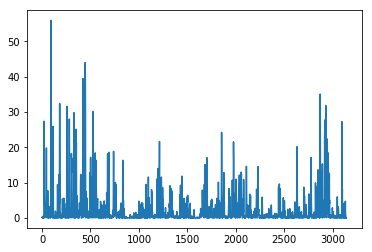

In [165]:
from matplotlib import pyplot as plt

temp = float_data[:, 0]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

In [166]:
mean = float_data[:2000].mean(axis=0)
float_data -= mean
std = float_data[:2000].std(axis=0)
float_data /= std

In [167]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

In [231]:
lookback = 168
step = 6
delay = 24
batch_size = 40

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=1001,
                    max_index=2000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=2001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (2000 - 1001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 2001 - lookback) // batch_size

In [232]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 0]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.5633789124616465


In [237]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(1,
               dropout=0.1,
               recurrent_dropout=0.5,
               input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 9s 91ms/step - loss: 1.5154 - val_loss: 0.4265
Epoch 2/10
100/100 [==============================] - 4s 43ms/step - loss: 1.3847 - val_loss: 0.4256
Epoch 3/10
100/100 [==============================] - 4s 42ms/step - loss: 1.2424 - val_loss: 0.4216
Epoch 4/10
100/100 [==============================] - 5s 49ms/step - loss: 1.3431 - val_loss: 0.4221
Epoch 5/10
100/100 [==============================] - 4s 43ms/step - loss: 1.4323 - val_loss: 0.4241
Epoch 6/10
100/100 [==============================] - 4s 40ms/step - loss: 1.3332 - val_loss: 0.4251
Epoch 7/10
100/100 [==============================] - 5s 49ms/step - loss: 1.3475 - val_loss: 0.4249
Epoch 8/10
100/100 [==============================] - 4s 43ms/step - loss: 1.4302 - val_loss: 0.4260
Epoch 9/10
100/100 [==============================] - 4s 40ms/step - loss: 1.3681 - val_loss: 0.4264
Epoch 10/10
100/100 [==============================] - 4s 41ms/step - loss: 1.2267 - val_lo

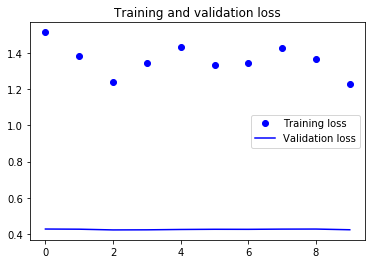

In [238]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

960
960
1.6766203261443906


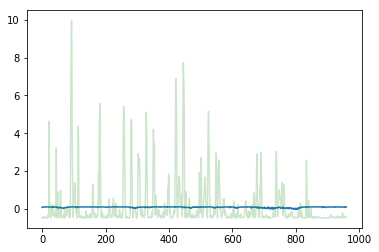

In [239]:
from sklearn.metrics import mean_squared_error

predictions = model.predict_generator(test_gen, test_steps)
true = float_data[:test_steps*batch_size]

print(len(predictions))
print(len(true))

mse = mean_squared_error(true, predictions)
print(mse)

temp = predictions[:, 0]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.plot(range(len(true)), true, color="green", alpha=0.2)
plt.show()


In [ ]:
import os

import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop

def create_csv_from_data(data):
    included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))
    data.set_index("Date Time", inplace=True)
    data.loc[included, ['surf_temp_sqerror']].to_csv('test_data.csv')

def drop_csv_data():
    os.remove("test_data.csv")
    
def normalize_data(float_data):
    mean = float_data[:2000].mean(axis=0)
    float_data -= mean
    std = float_data[:2000].std(axis=0)
    float_data /= std
    
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets
    
def build_generators(lookback, step, delay, batch_size):
    train_gen = generator(float_data,
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=1000,
                          shuffle=True,
                          step=step, 
                          batch_size=batch_size)
    val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=1001,
                        max_index=2000,
                        step=step,
                        batch_size=batch_size)
    test_gen = generator(float_data,
                         lookback=lookback,
                         delay=delay,
                         min_index=2001,
                         max_index=None,
                         step=step,
                         batch_size=batch_size)
    
    return train_gen, val_gen, test_gen

def get_val_steps(lookback, batch_size):
    # This is how many steps to draw from `val_gen`
    # in order to see the whole validation set:
    val_steps = (2000 - 1001 - lookback) // batch_size
    return val_steps

def get_test_steps(lookback, batch_size):
    # This is how many steps to draw from `test_gen`
    # in order to see the whole test set:
    test_steps = (len(float_data) - 2001 - lookback) // batch_size

def fit_model(float_data, 
              neurons=1, 
              dropout=0.1, 
              rdropout=0.5, 
              steps_per_epoch=100, 
              epochs=10,
              val_steps,
              val_gen):
    model = Sequential()
    model.add(LSTM(neurons,
                   dropout=dropout,
                   recurrent_dropout=rdropout,
                   input_shape=(None, float_data.shape[-1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)

def get_best_parameters(train_gen, val_gen):
    model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=50, verbose=0) 

    # Define the range
    neurons = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
    batch_size = [10, 20, 40, 50, 60, 80, 100]
    epochs = [10, 20, 40, 50, 100]
    param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs)
    
    dnn_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 3, verbose=2, n_iter = 100)
    dnn_random.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)
    
    return dnn_random.best_params_

In [117]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import nan, nanmean, isnan
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))

    float_data = data.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

    nmean = nanmean(float_data)
    where_are_NaNs = isnan(float_data)
    float_data[where_are_NaNs] = 0
    return float_data


Using TensorFlow backend.


In [118]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [15]:
def experiment(repeats, data, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[features:,:]
    print(int(len(float_data) * .3))
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        lstm_model = fit_lstm(train_scaled, 1, 10, 10)
        
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
    return error_scores

942
1) Test MSE: 0.243
2) Test MSE: 0.238
3) Test MSE: 0.252
4) Test MSE: 0.254
5) Test MSE: 0.249
6) Test MSE: 0.250
7) Test MSE: 0.252
8) Test MSE: 0.236
9) Test MSE: 0.240
10) Test MSE: 0.245
942
1) Test MSE: 8.516
2) Test MSE: 8.772
3) Test MSE: 9.802
4) Test MSE: 9.015
5) Test MSE: 8.383
6) Test MSE: 8.563
7) Test MSE: 9.911
8) Test MSE: 9.296
9) Test MSE: 8.550
10) Test MSE: 8084.205
942
1) Test MSE: 5.787
2) Test MSE: 6.151
3) Test MSE: 5.912
4) Test MSE: 6.038
5) Test MSE: 5.954
6) Test MSE: 6.026
7) Test MSE: 6.156
8) Test MSE: 6.031
9) Test MSE: 5.936
10) Test MSE: 5.885
942
1) Test MSE: 6.512
2) Test MSE: 10.465
3) Test MSE: 6.978
4) Test MSE: 6.568
5) Test MSE: 235.585
6) Test MSE: 6.641
7) Test MSE: 6.225
8) Test MSE: 8.571
9) Test MSE: 9.435
10) Test MSE: 22.749
942
1) Test MSE: 0.112
2) Test MSE: 0.109
3) Test MSE: 0.116
4) Test MSE: 0.112
5) Test MSE: 0.117
6) Test MSE: 0.114
7) Test MSE: 0.112
8) Test MSE: 0.112
9) Test MSE: 0.111
10) Test MSE: 0.113
942
1) Test MSE: 2

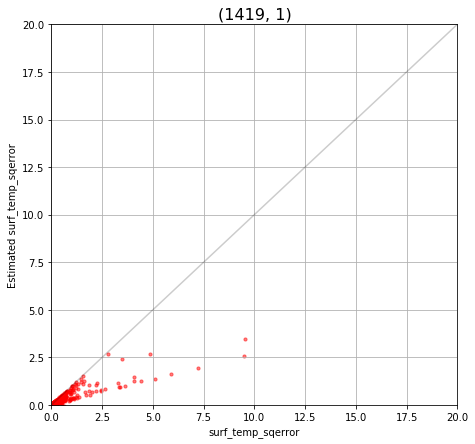

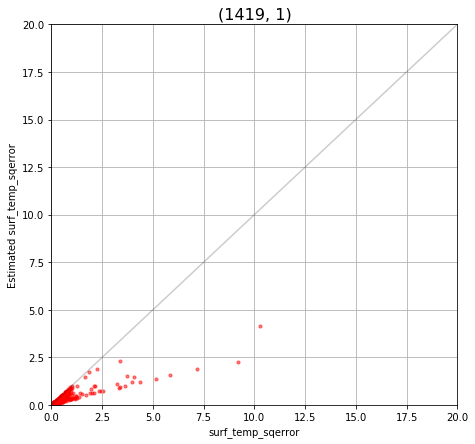

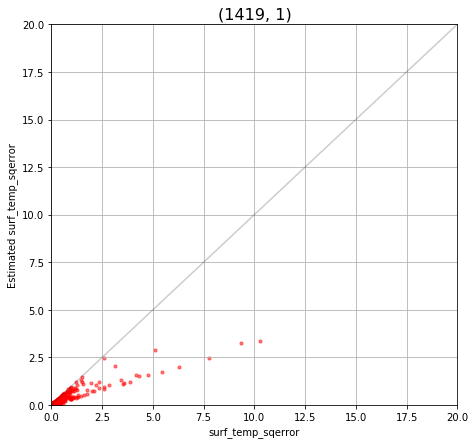

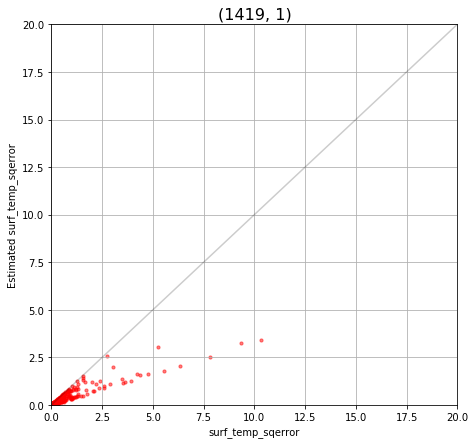

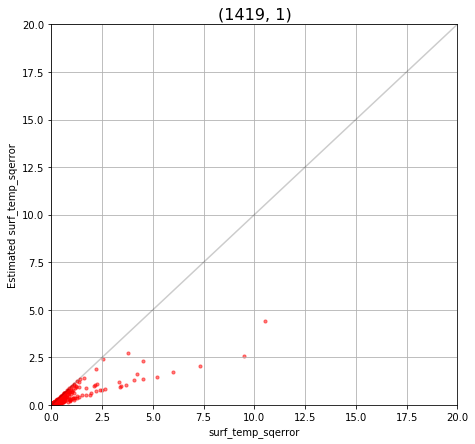

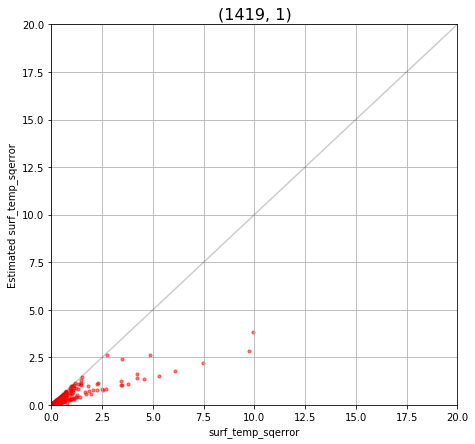

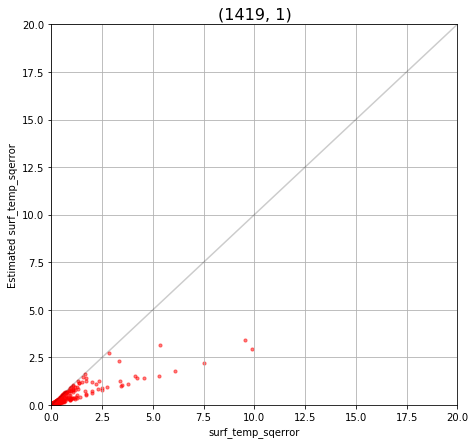

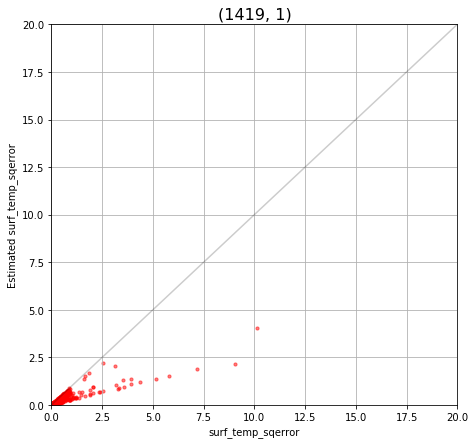

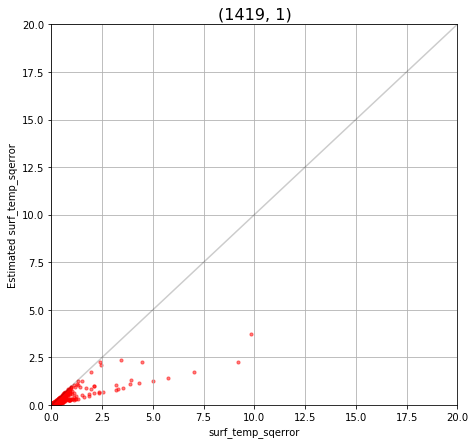

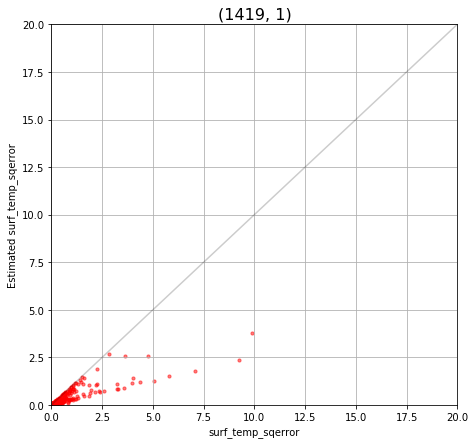

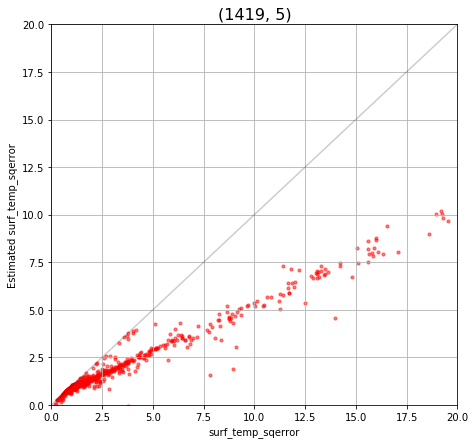

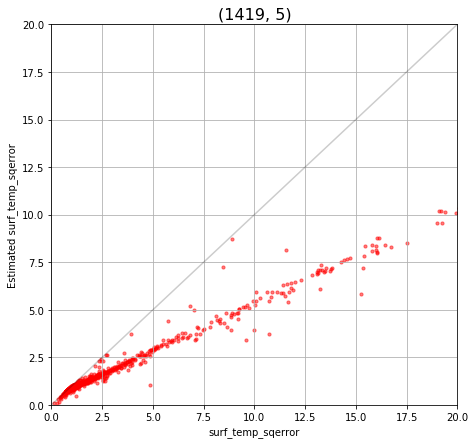

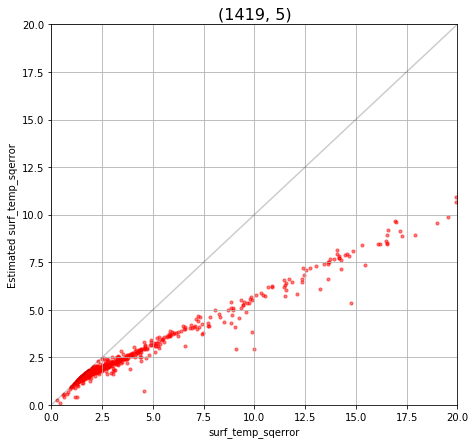

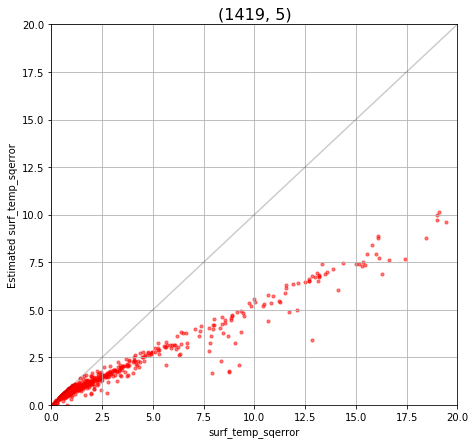

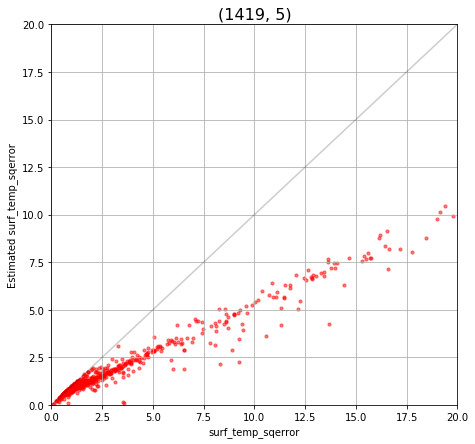

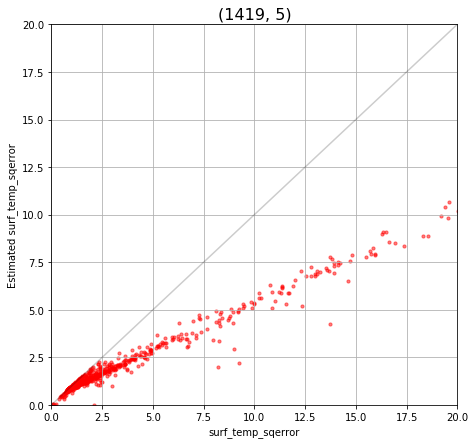

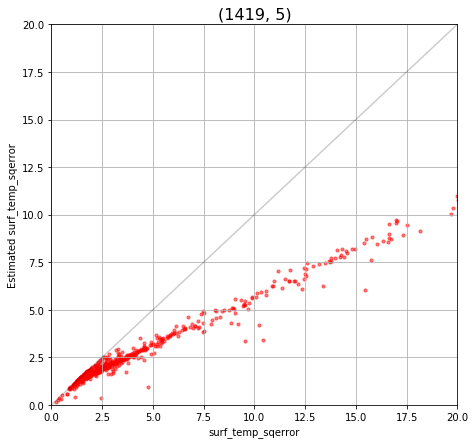

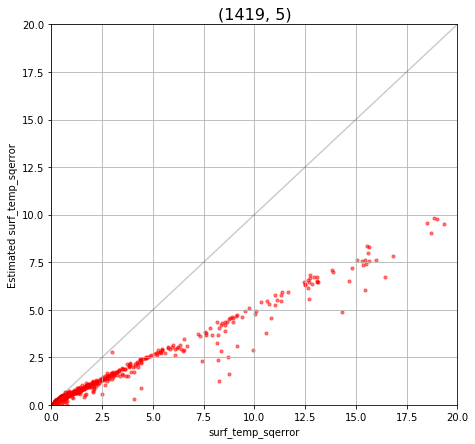

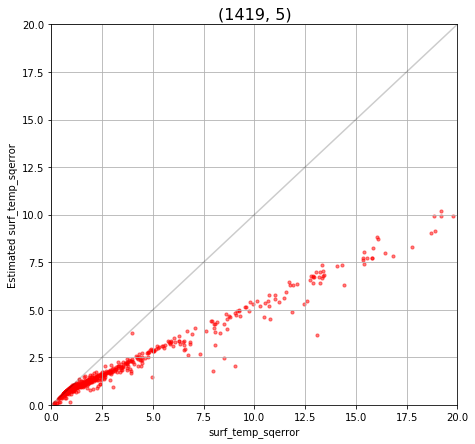

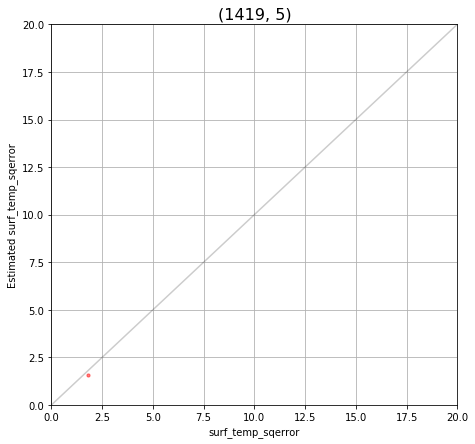

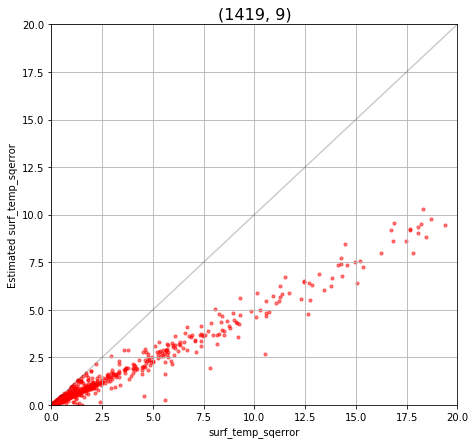

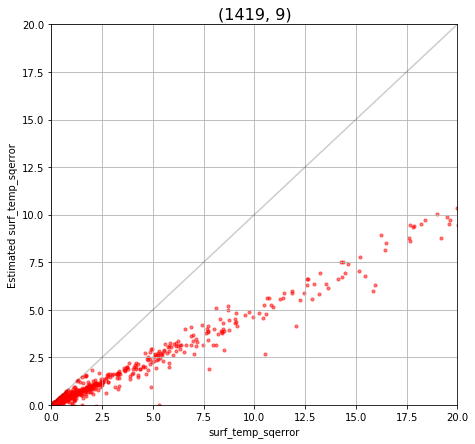

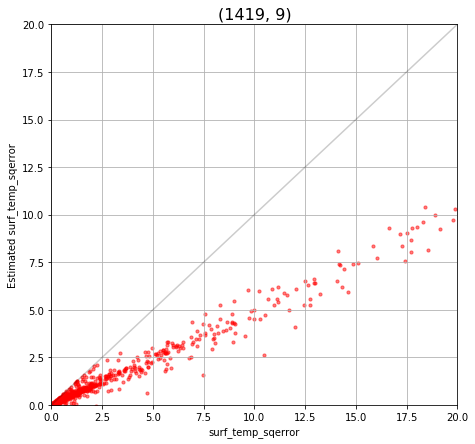

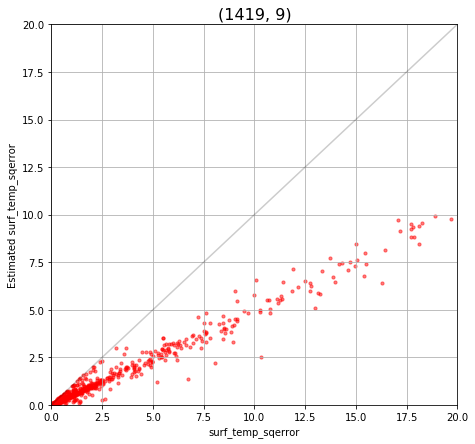

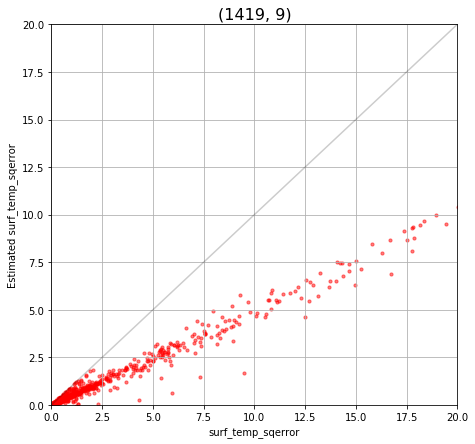

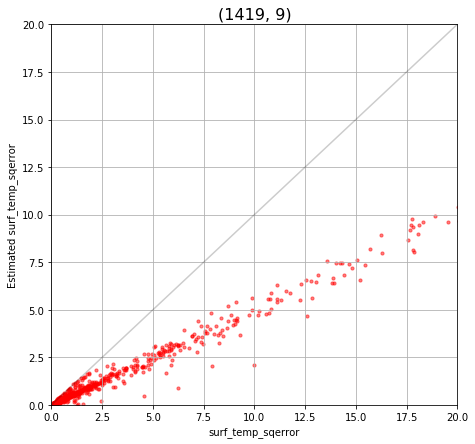

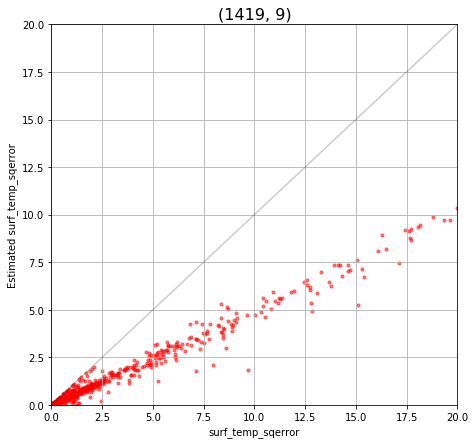

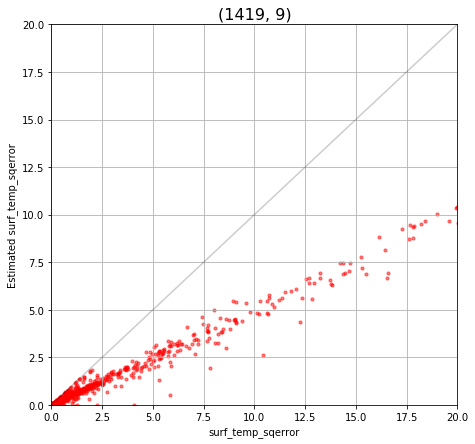

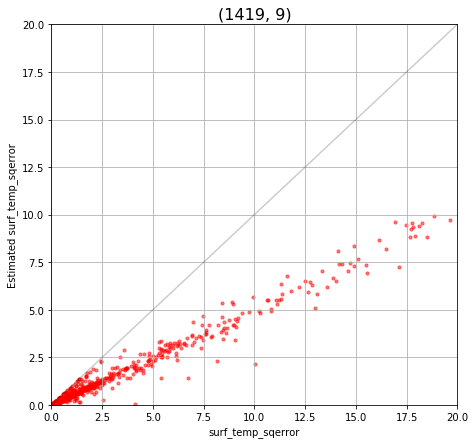

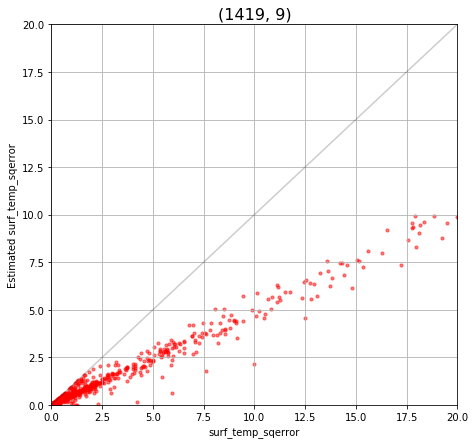

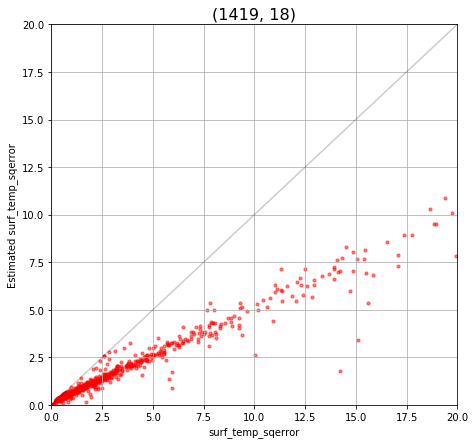

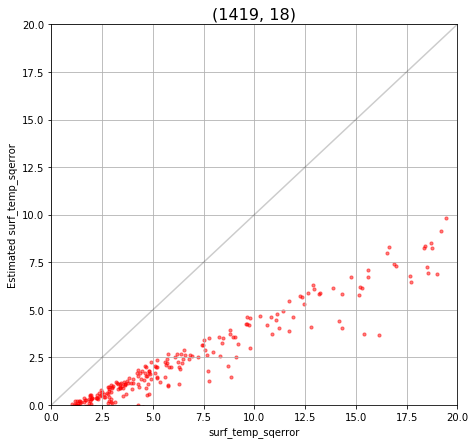

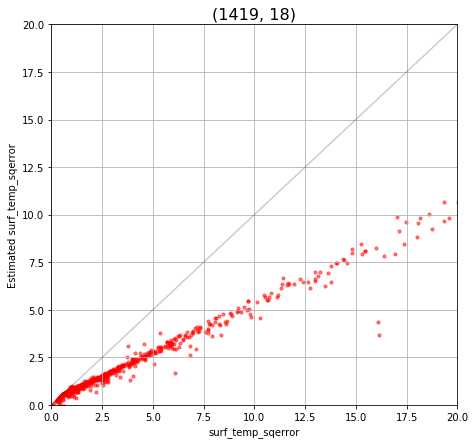

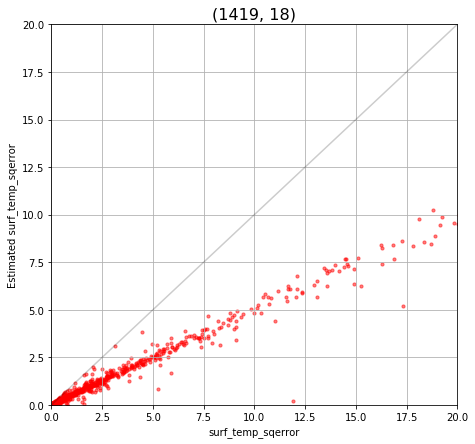

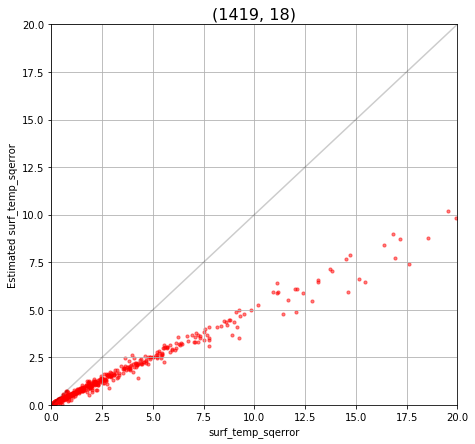

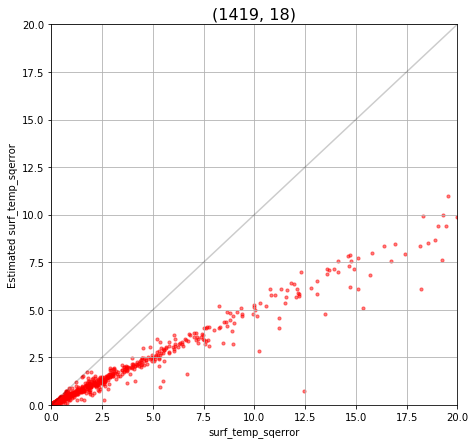

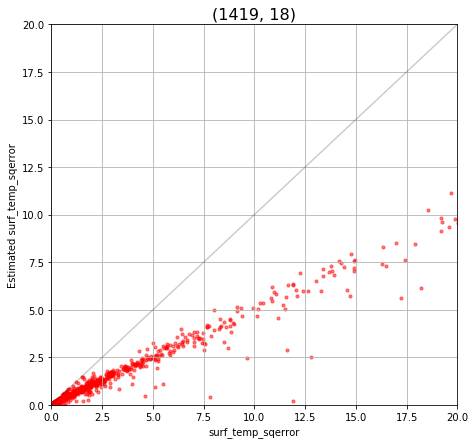

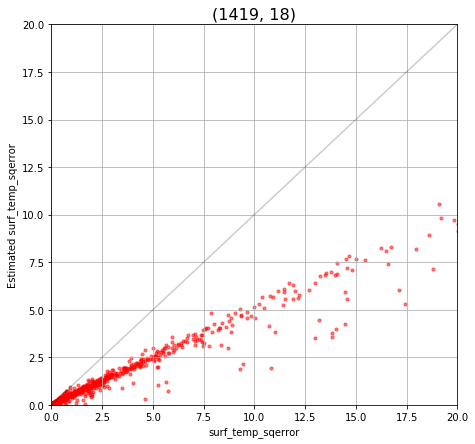

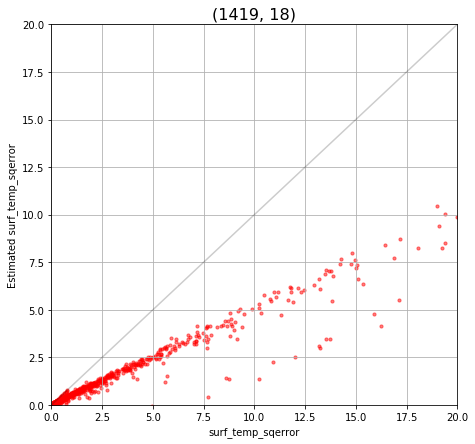

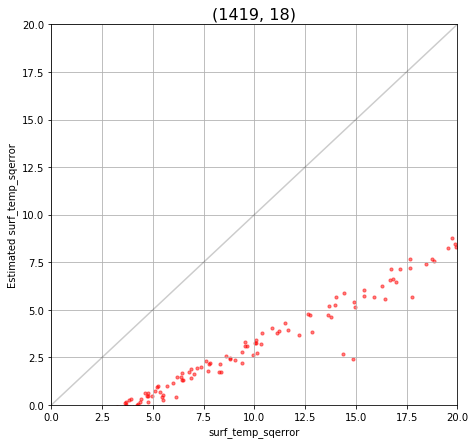

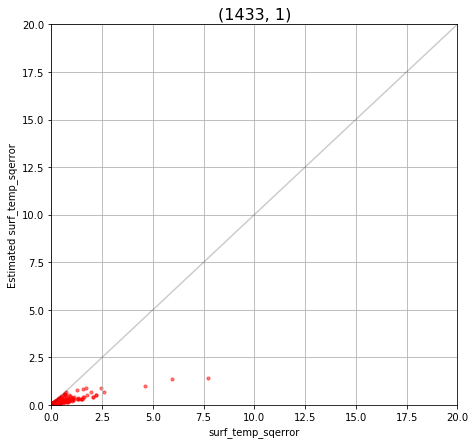

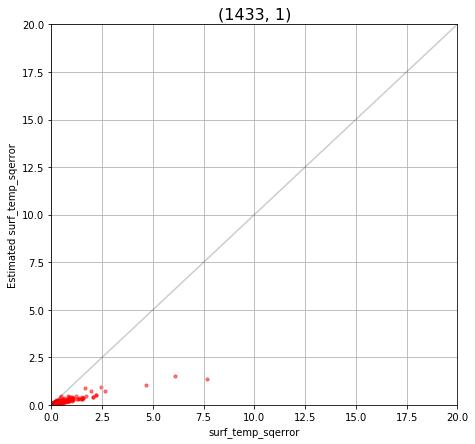

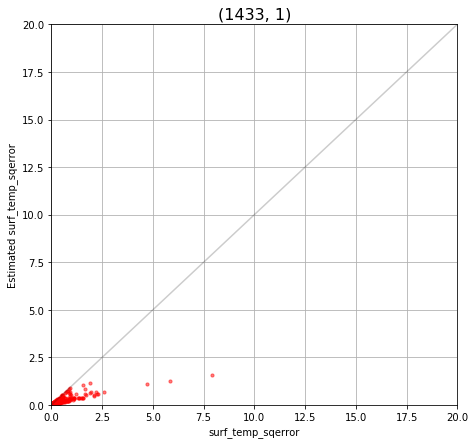

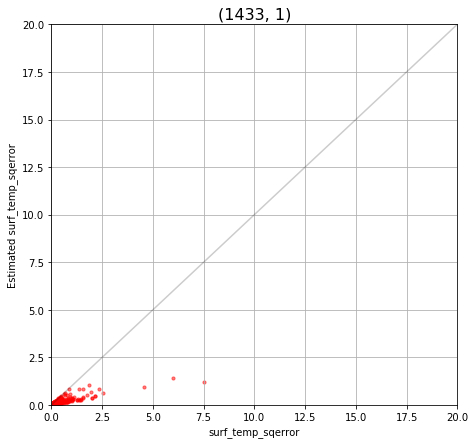

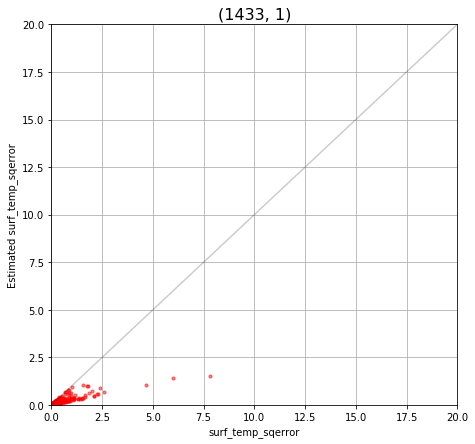

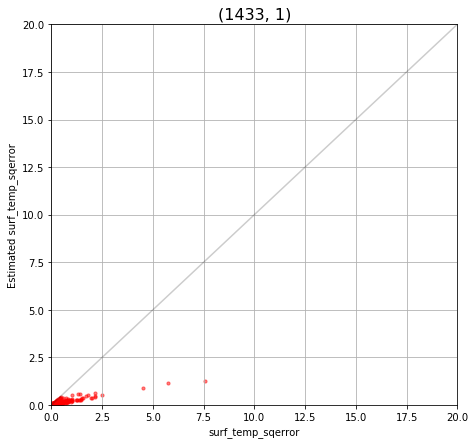

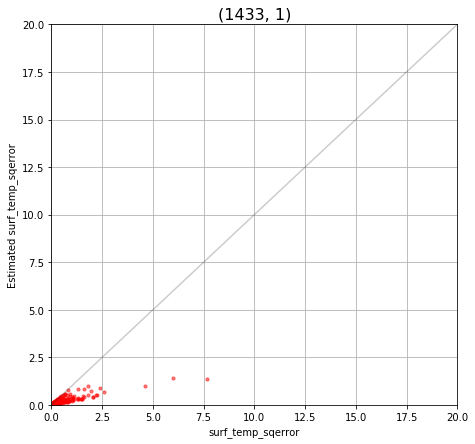

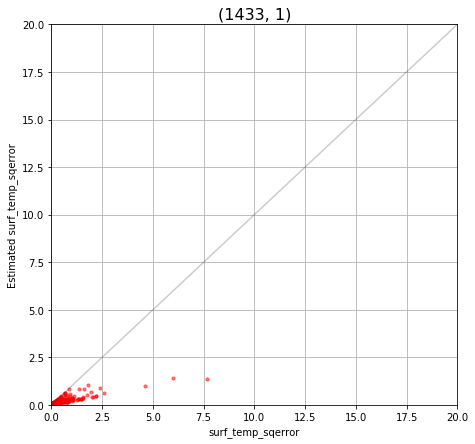

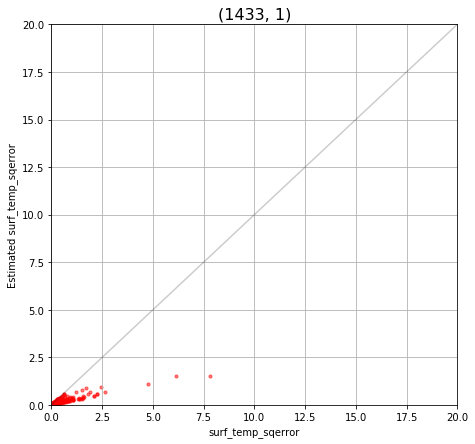

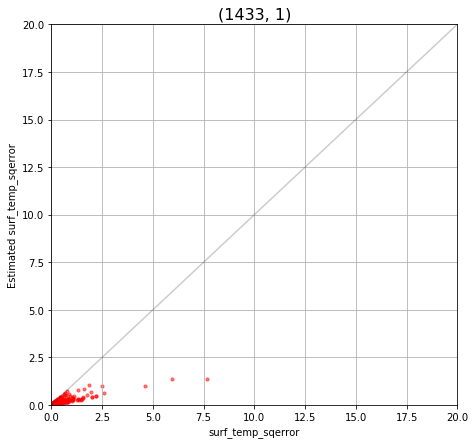

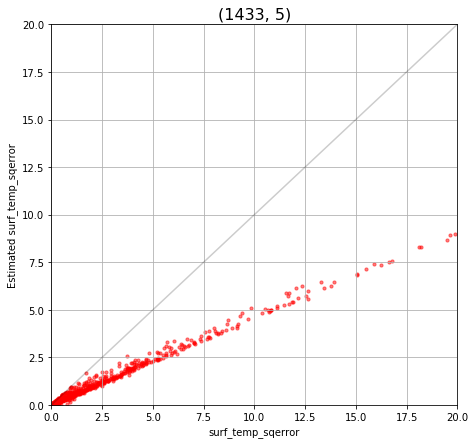

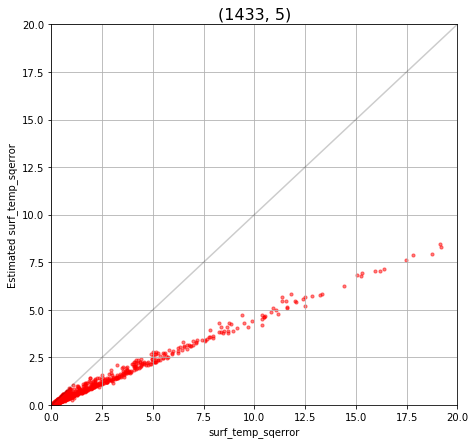

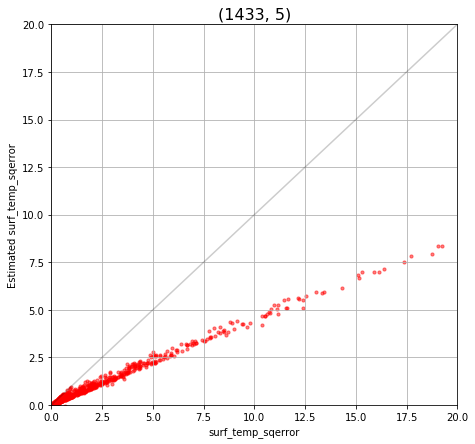

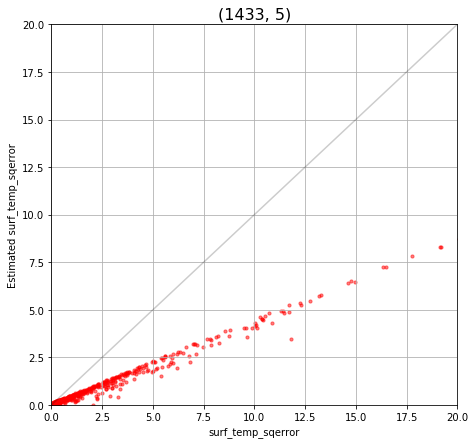

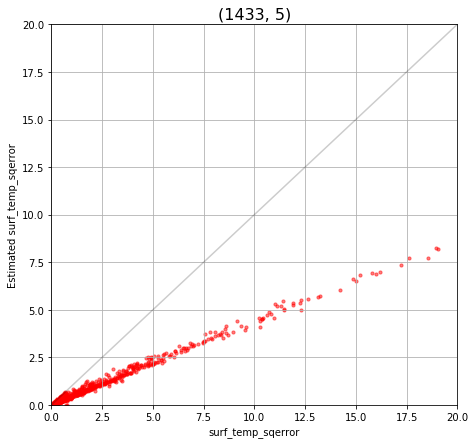

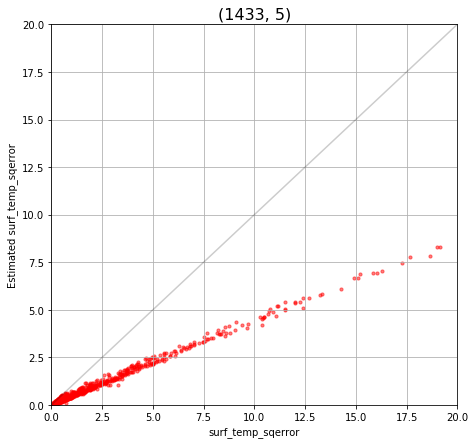

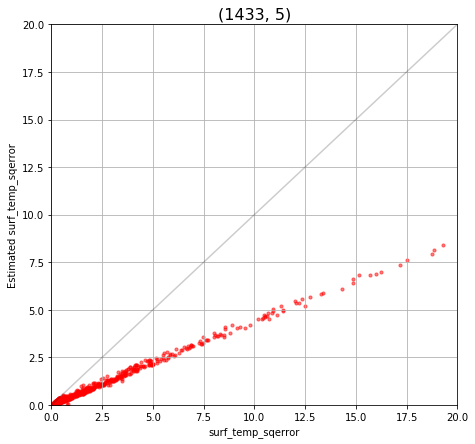

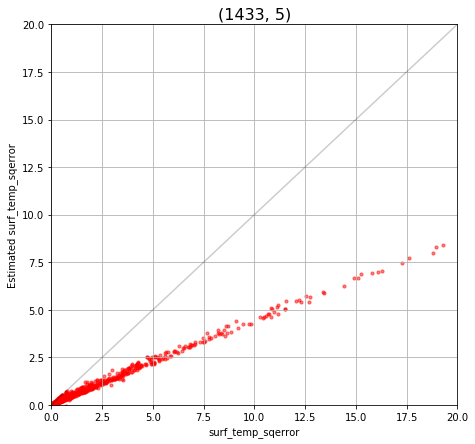

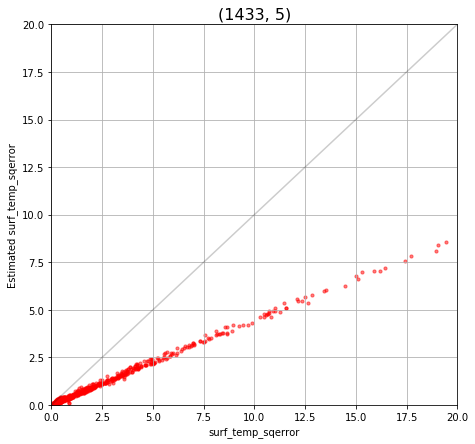

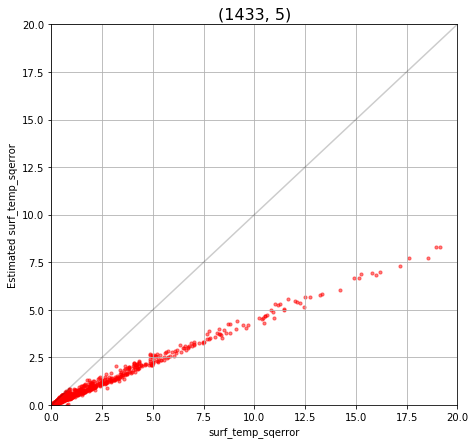

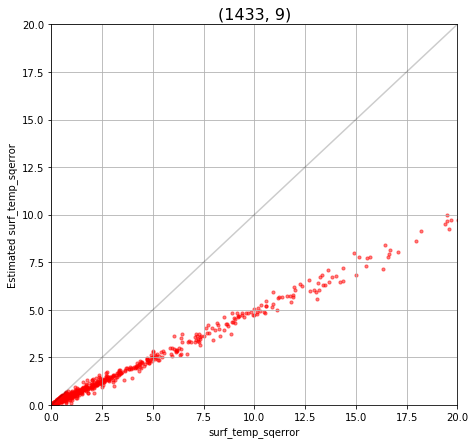

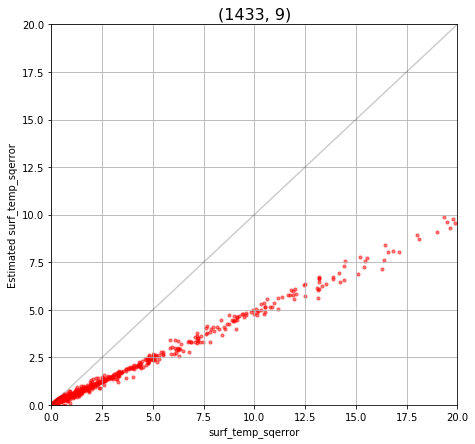

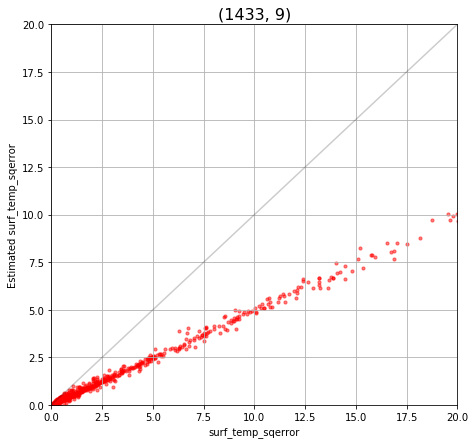

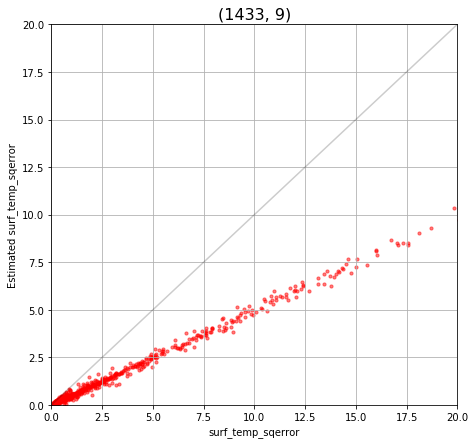

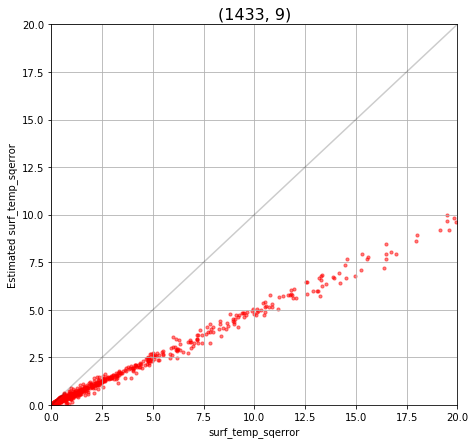

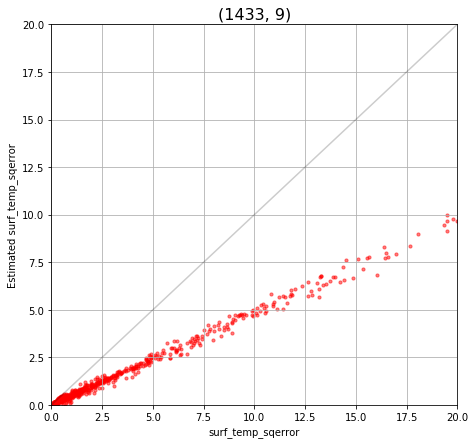

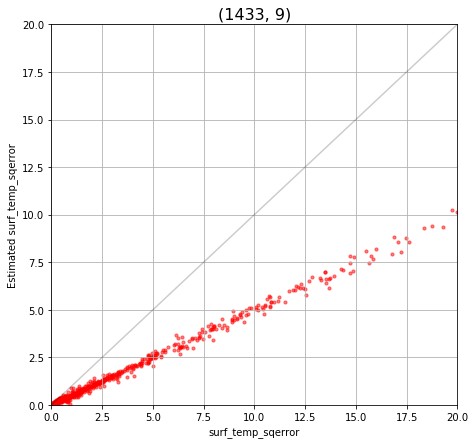

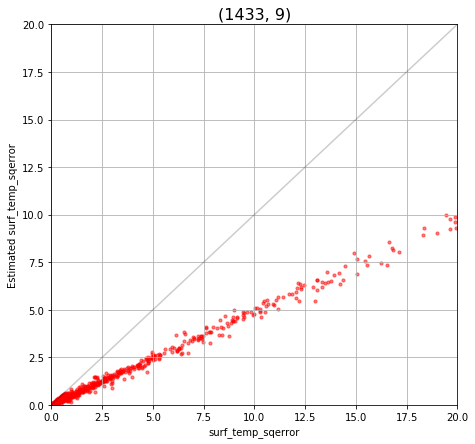

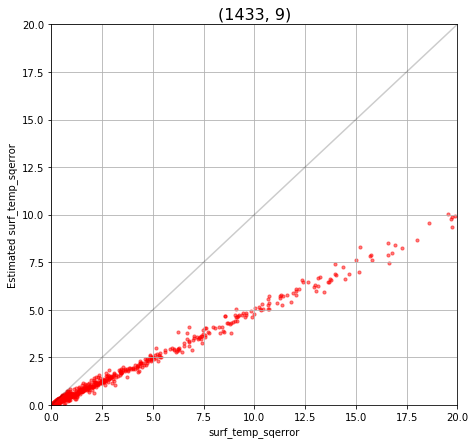

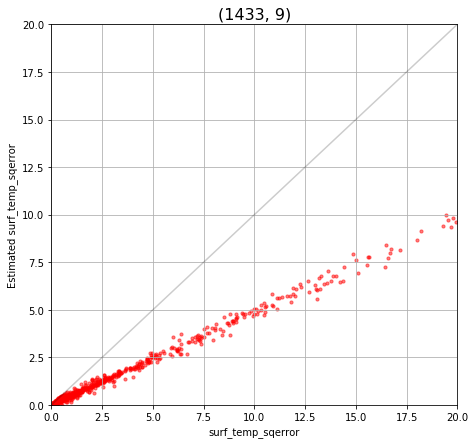

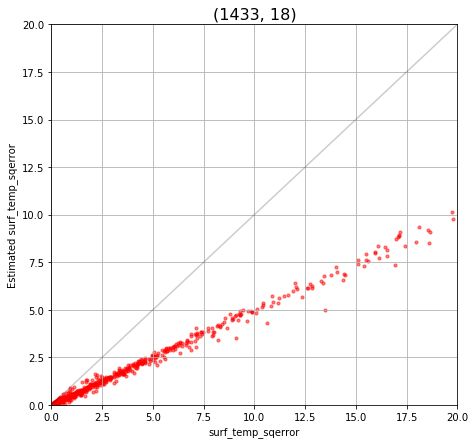

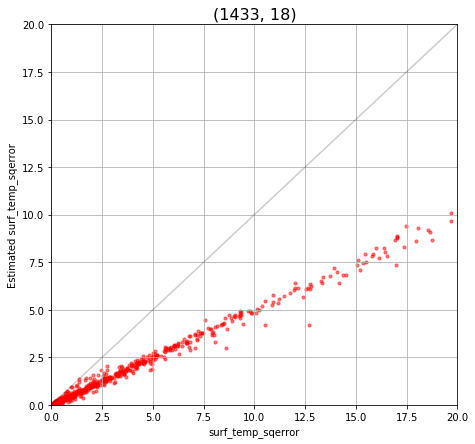

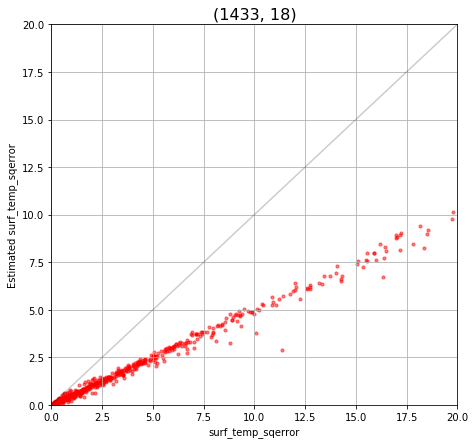

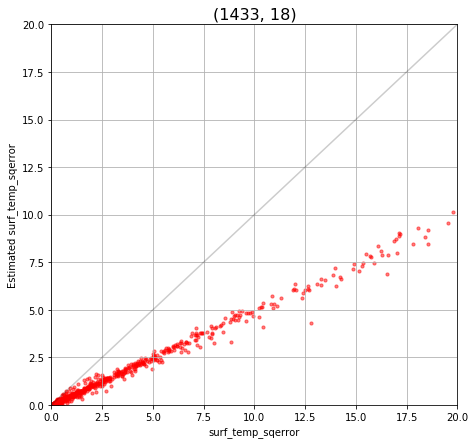

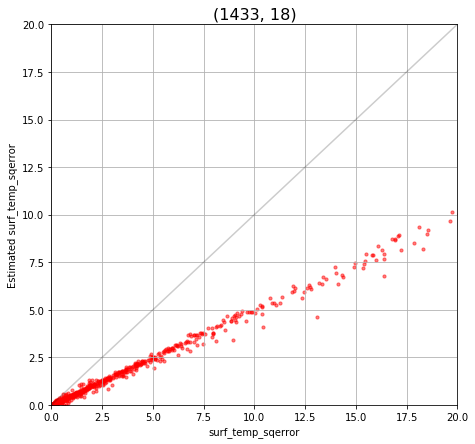

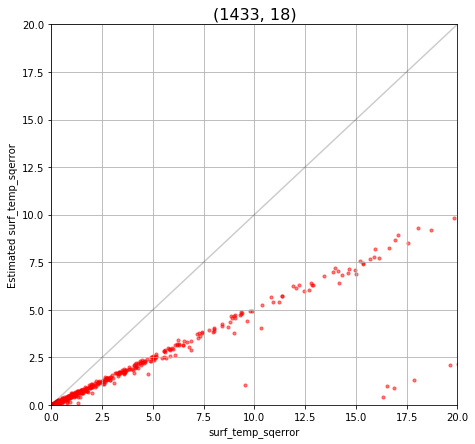

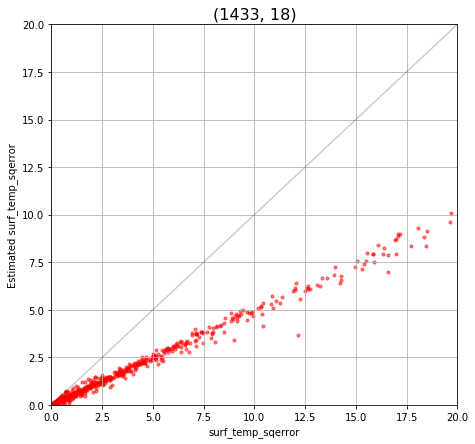

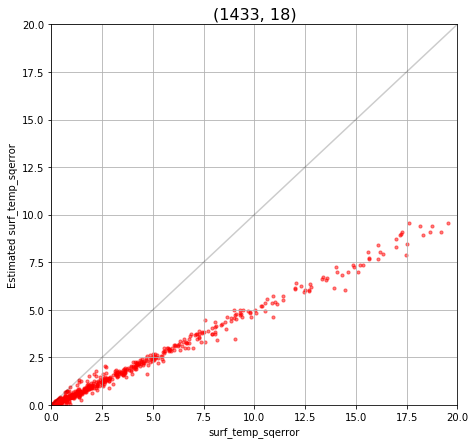

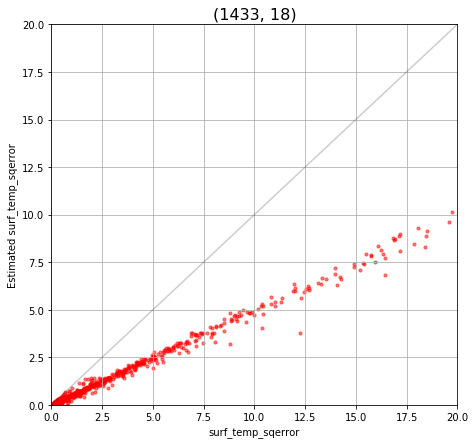

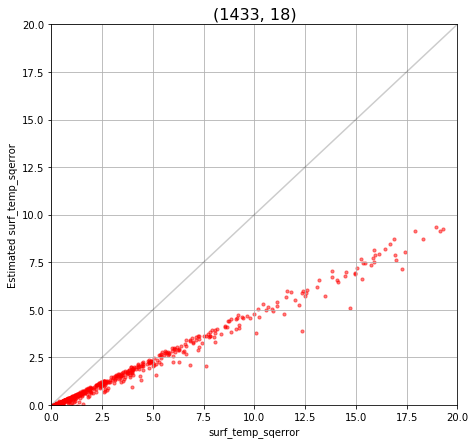

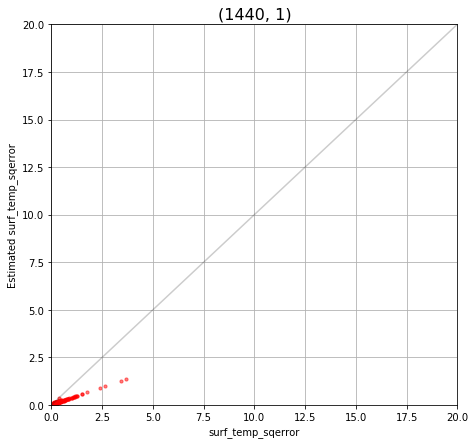

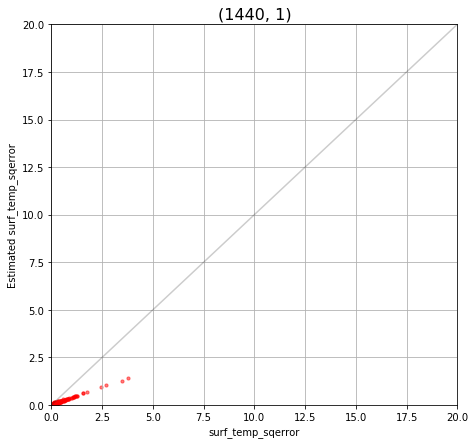

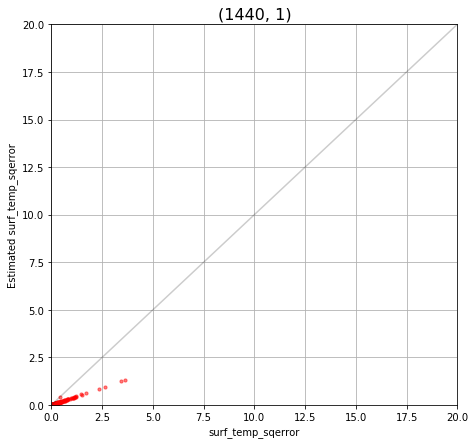

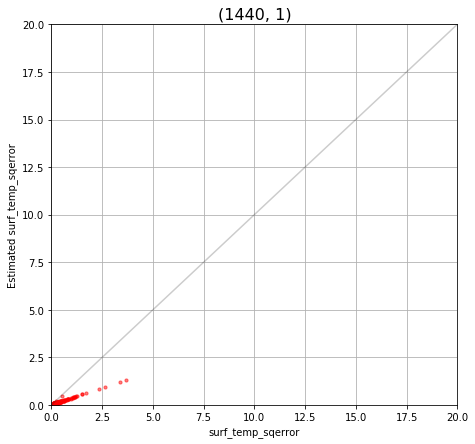

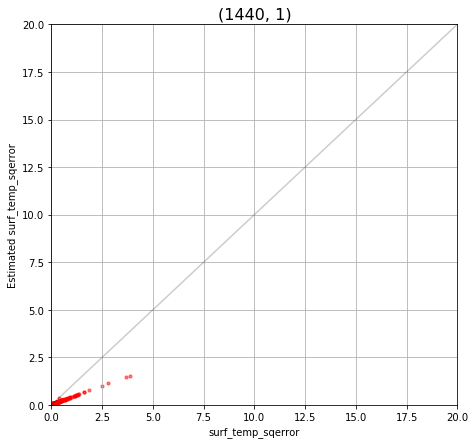

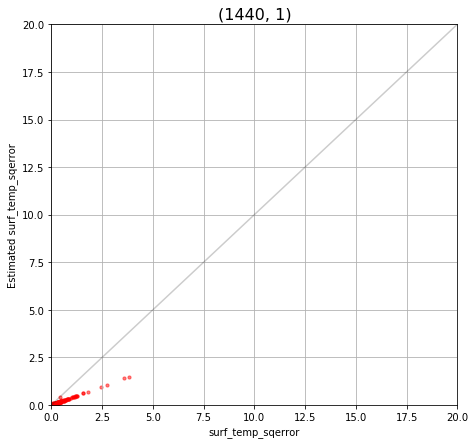

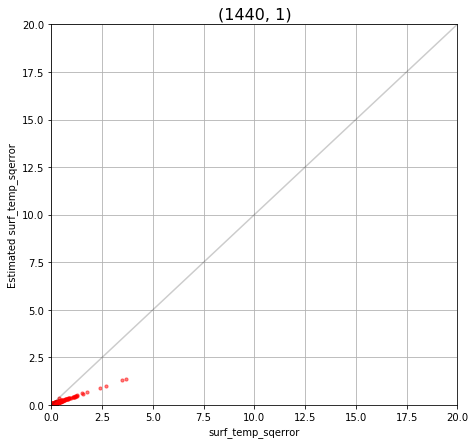

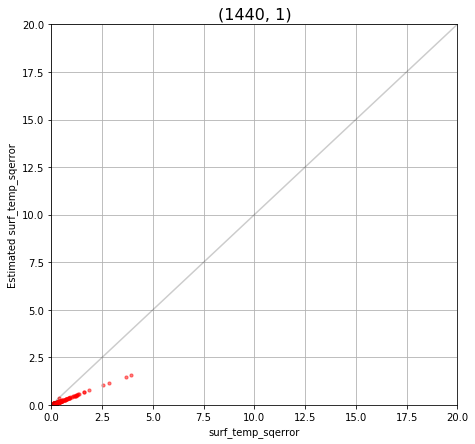

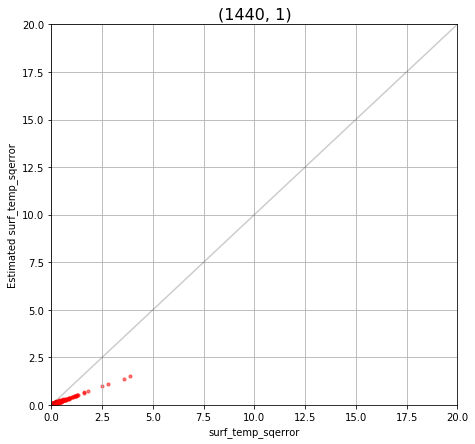

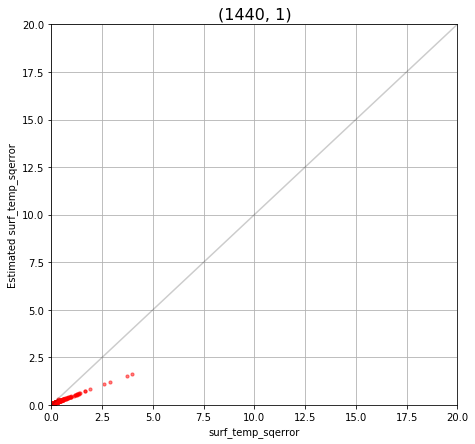

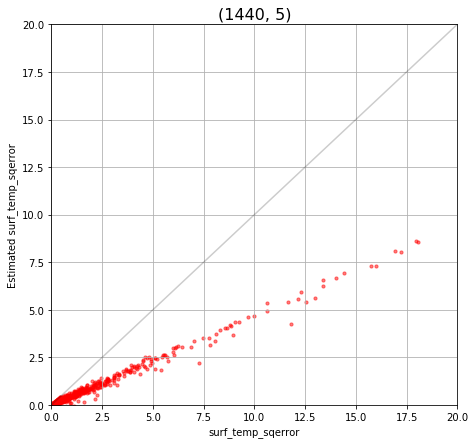

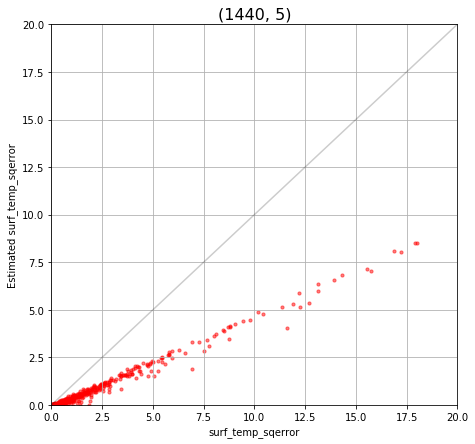

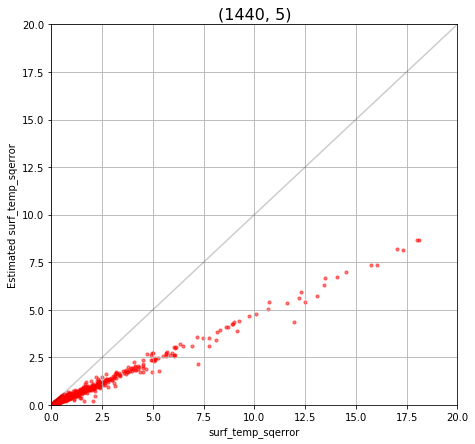

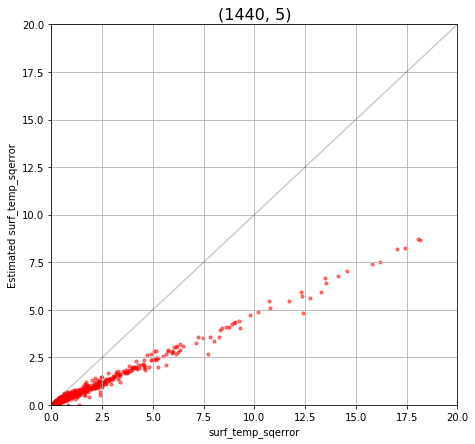

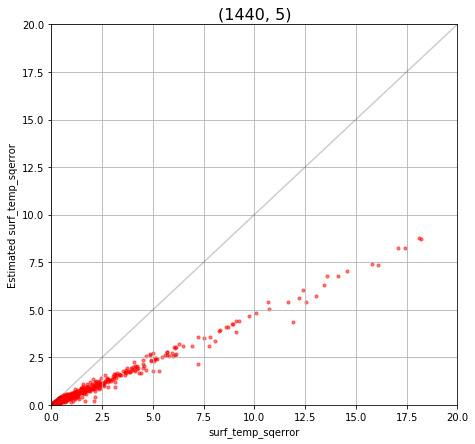

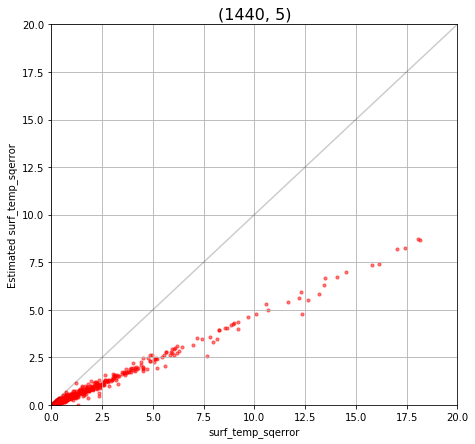

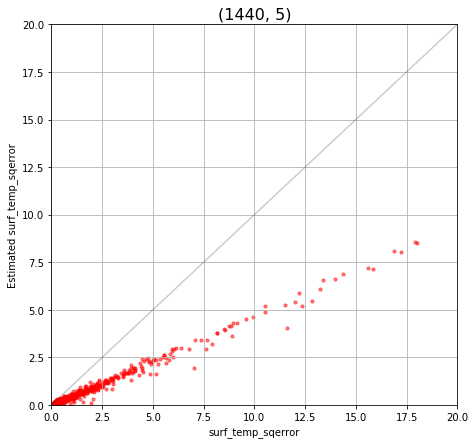

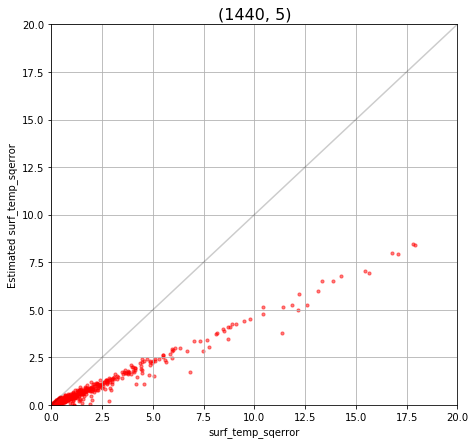

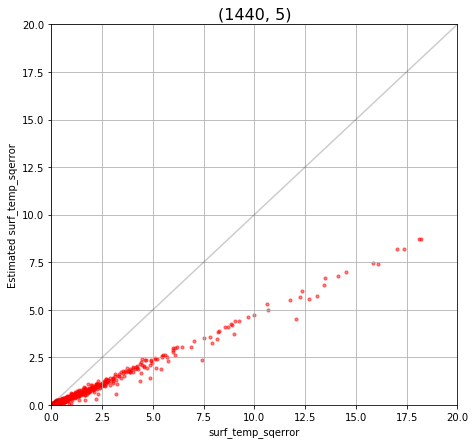

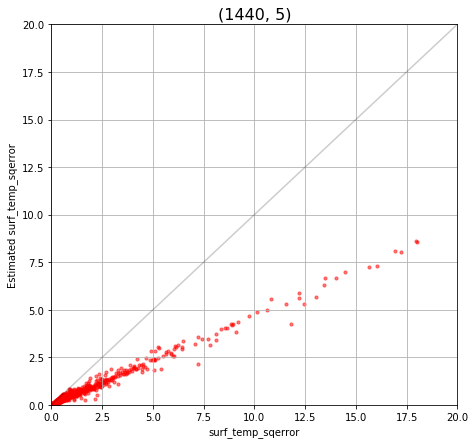

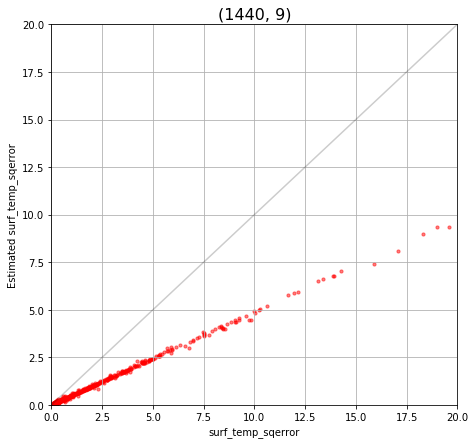

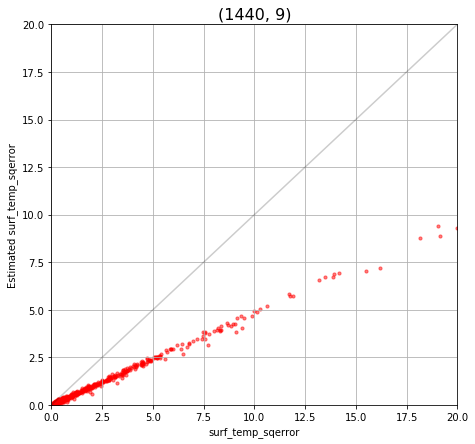

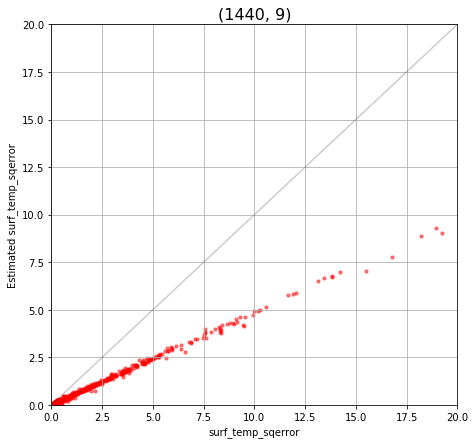

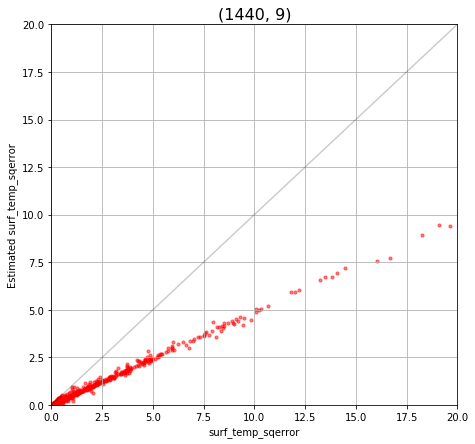

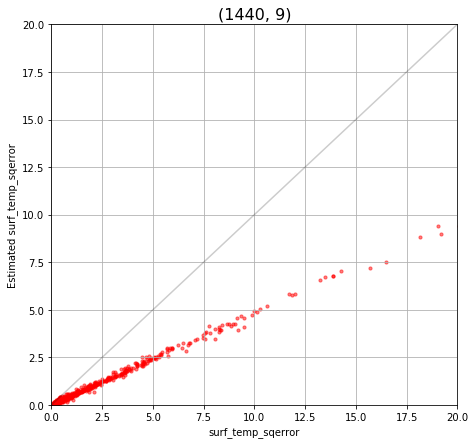

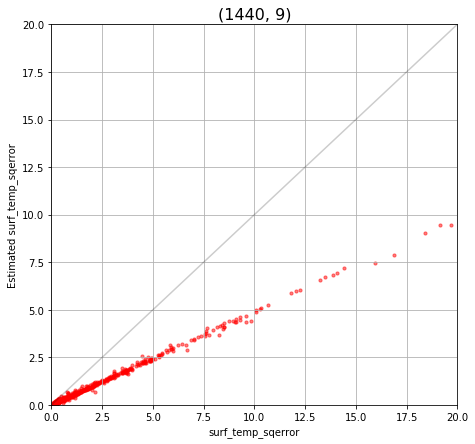

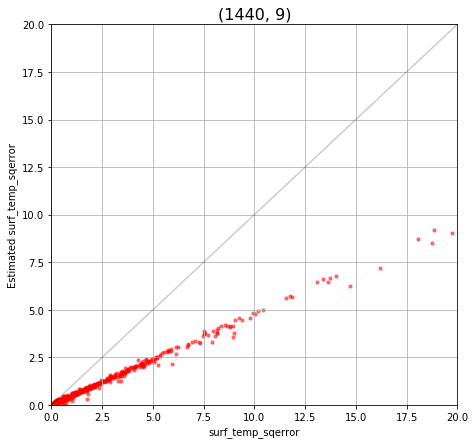

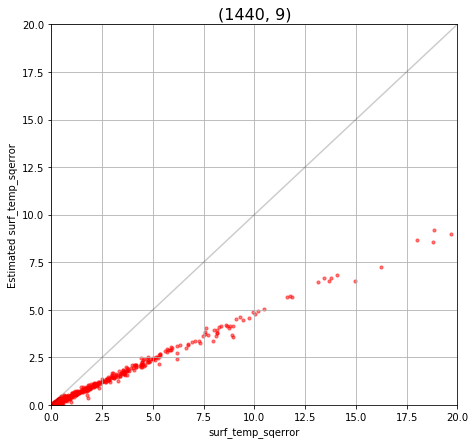

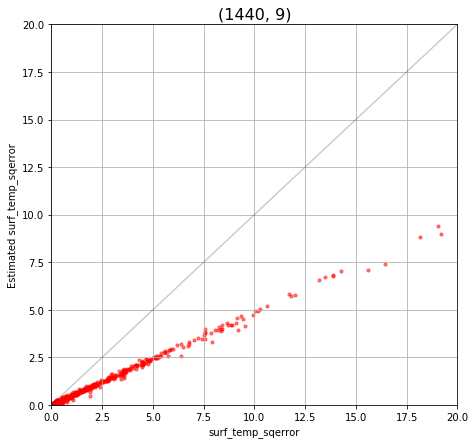

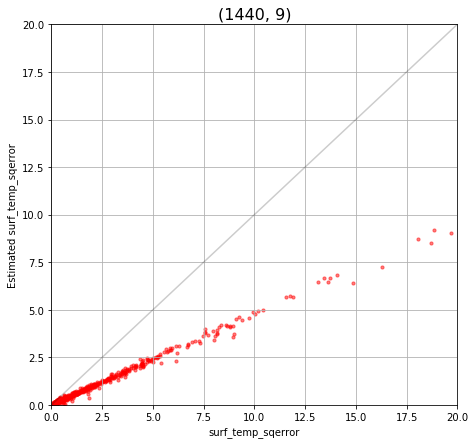

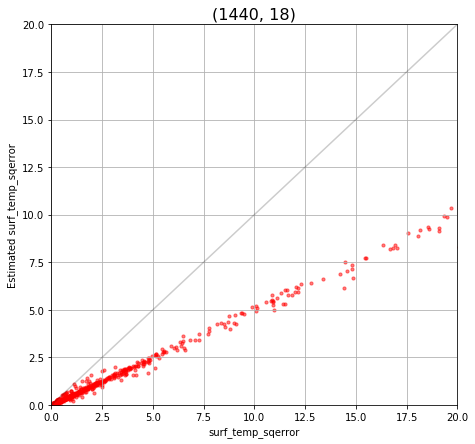

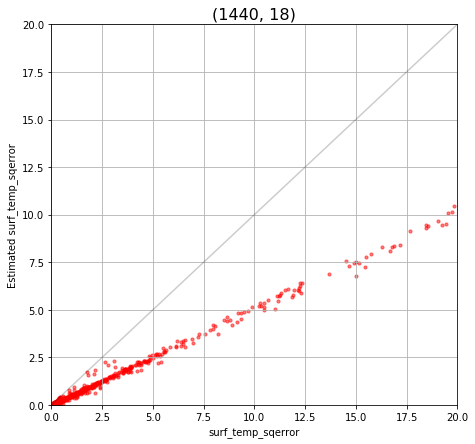

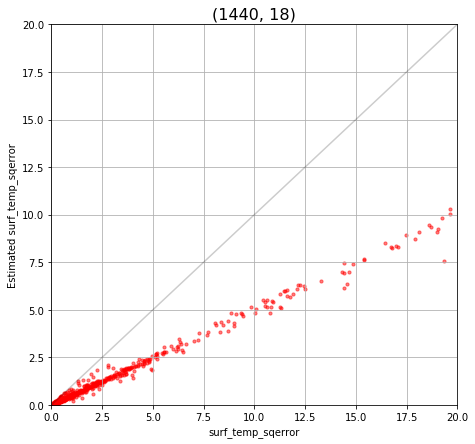

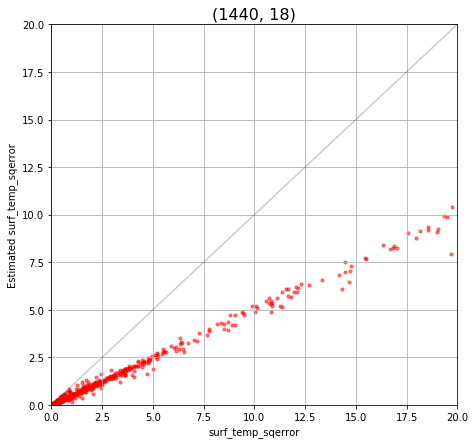

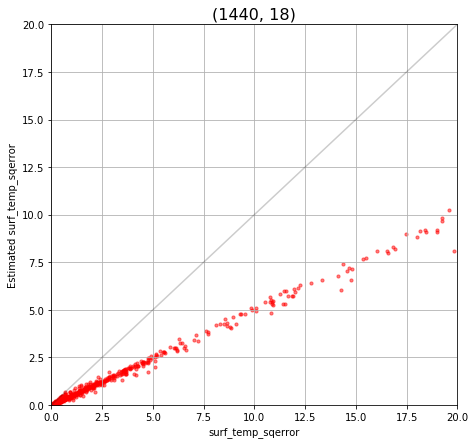

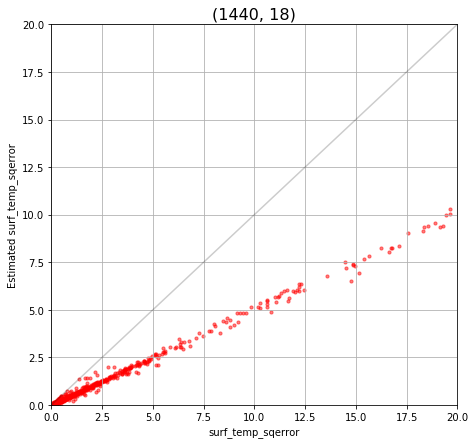

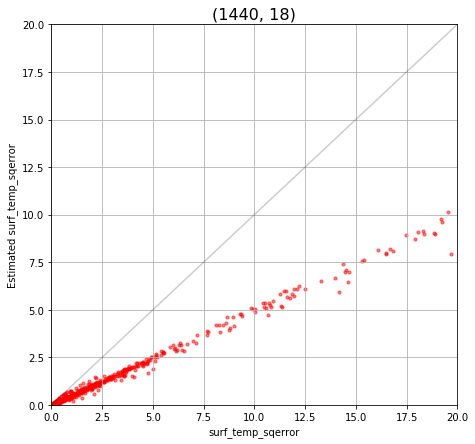

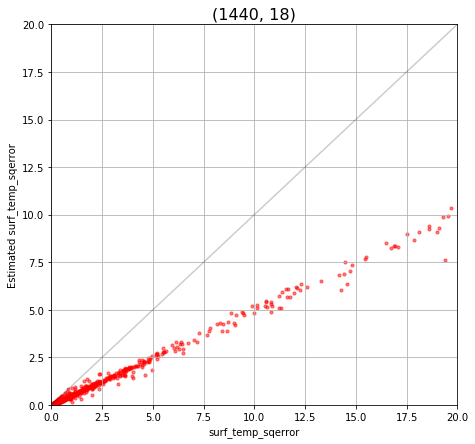

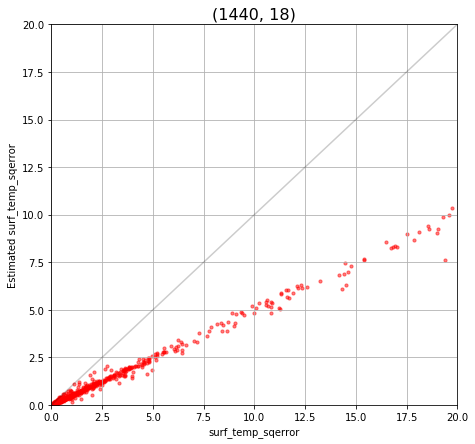

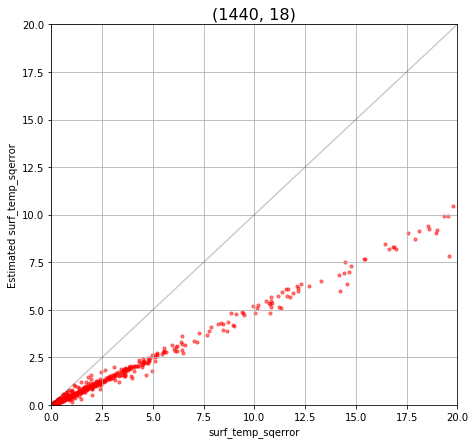

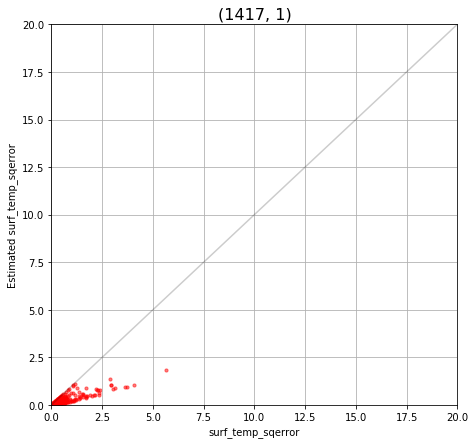

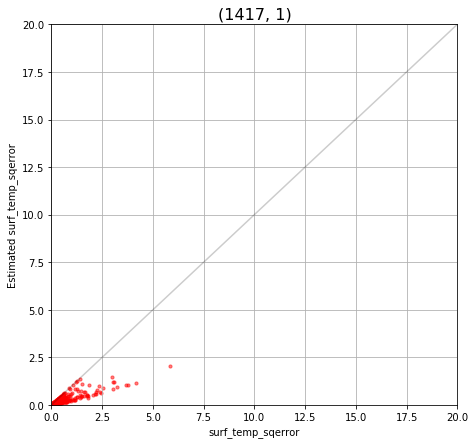

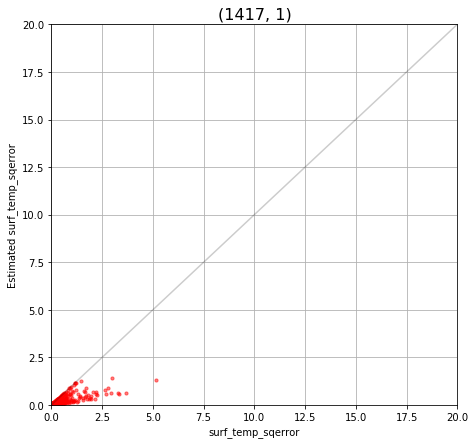

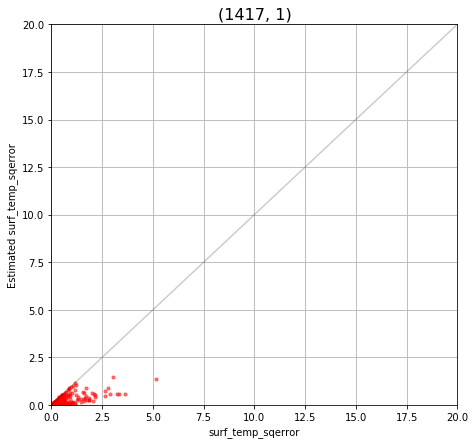

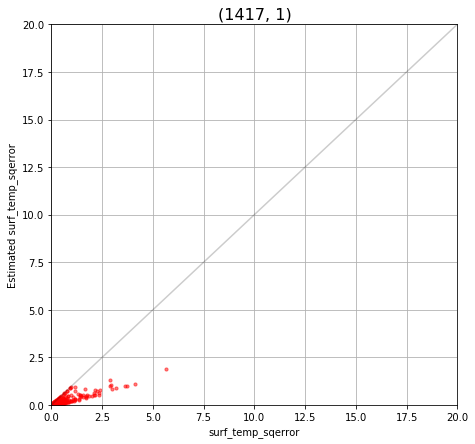

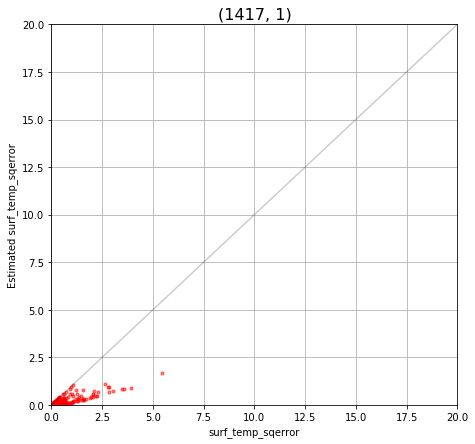

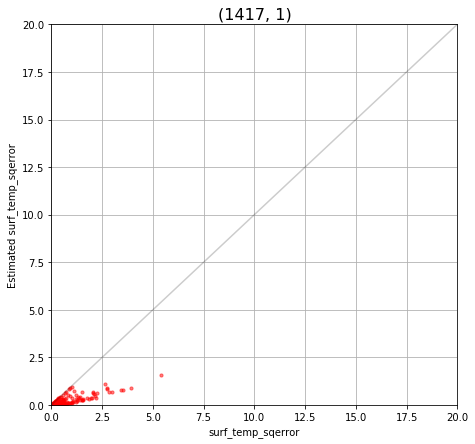

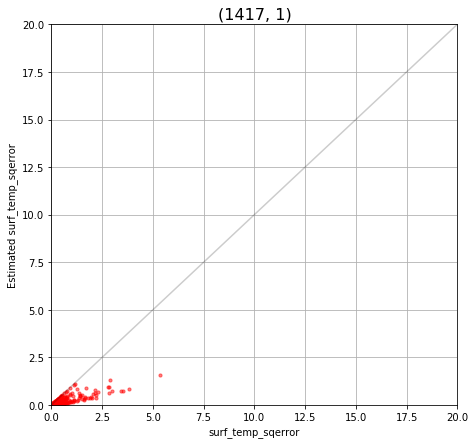

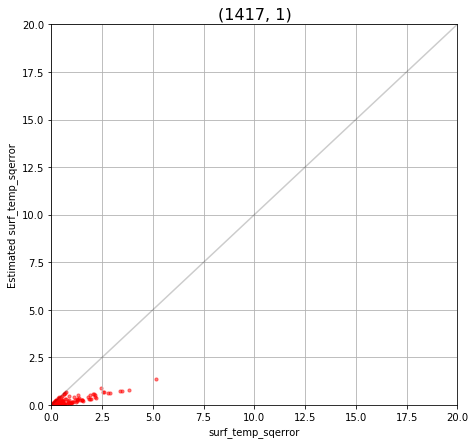

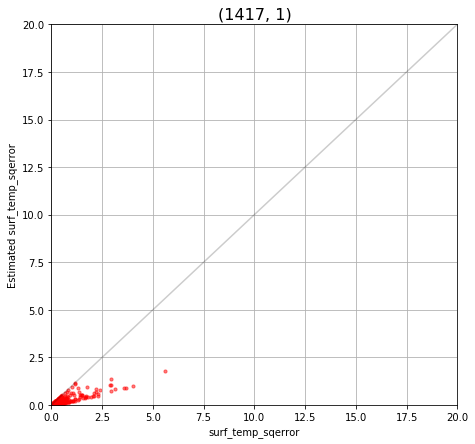

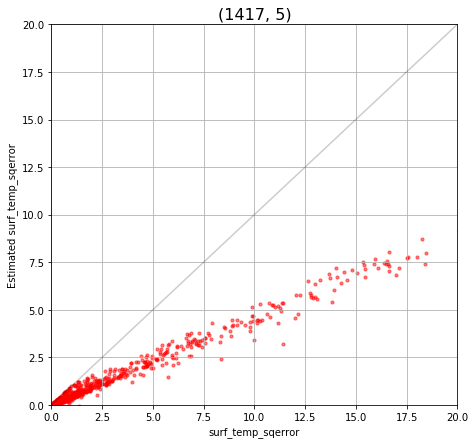

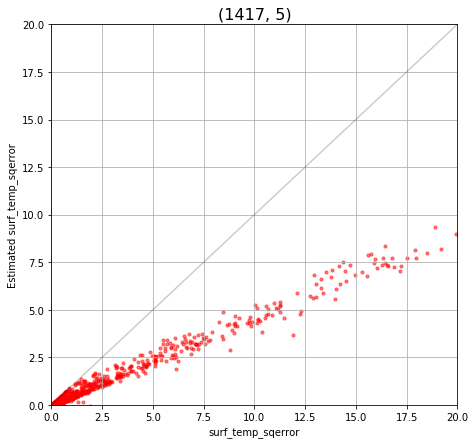

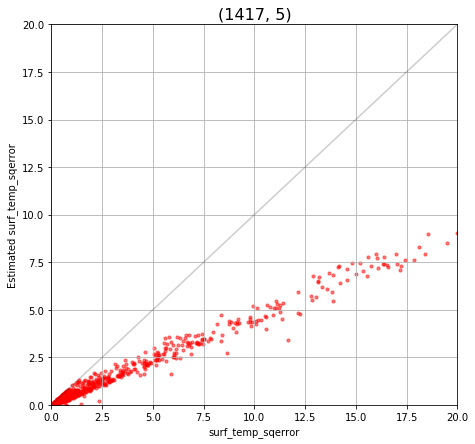

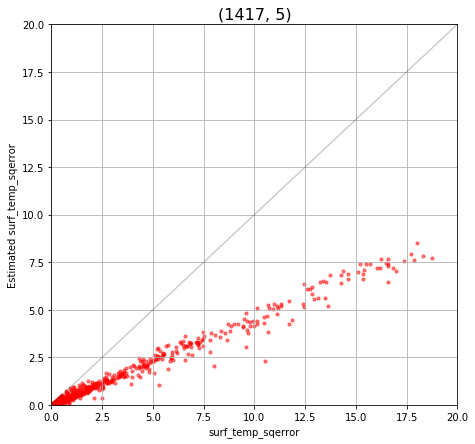

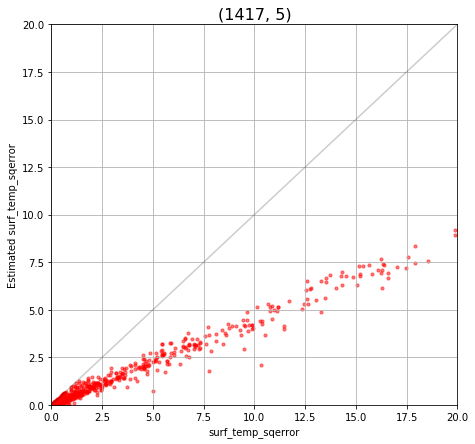

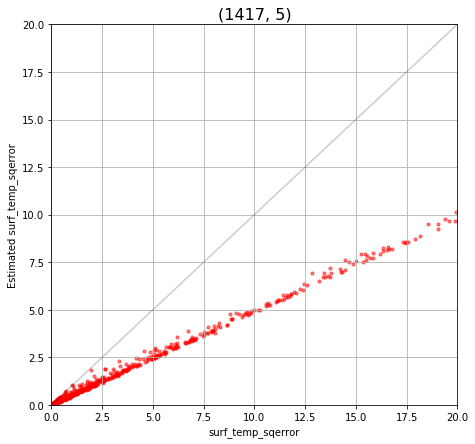

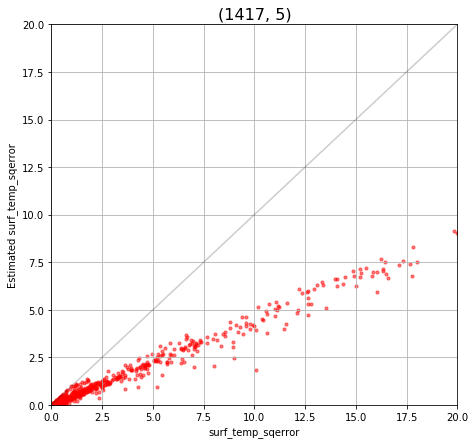

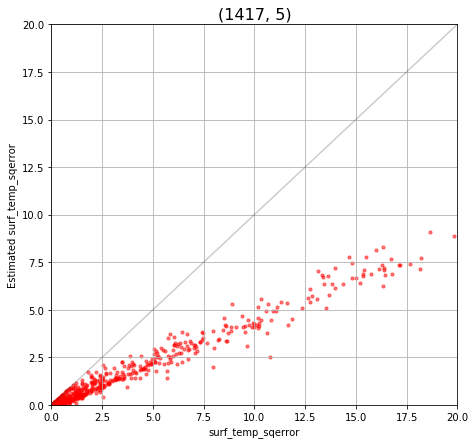

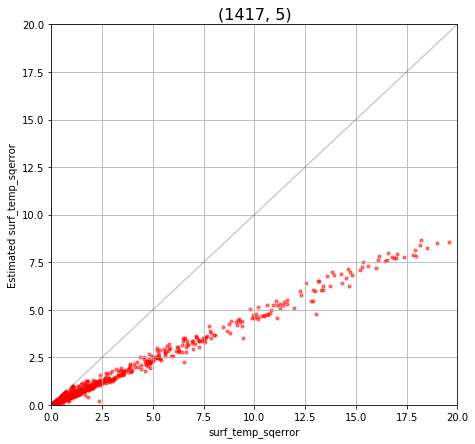

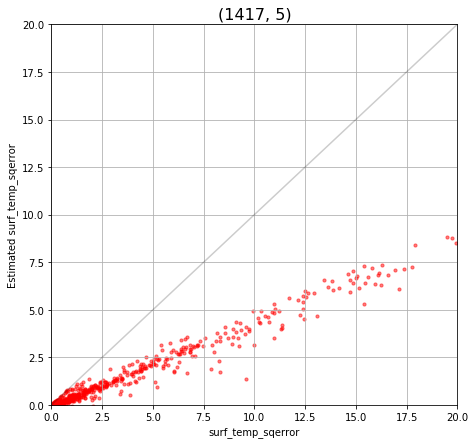

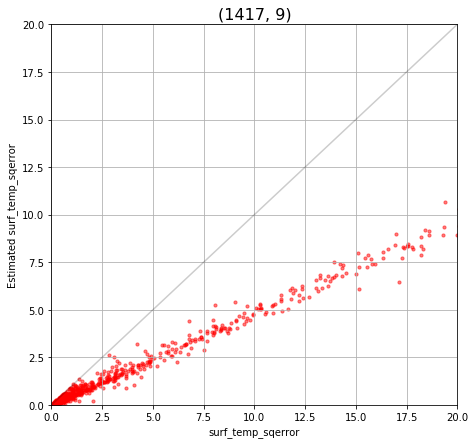

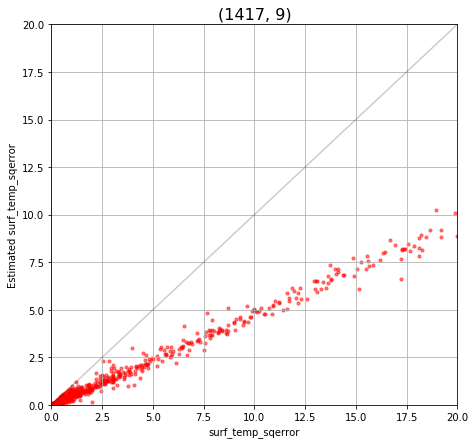

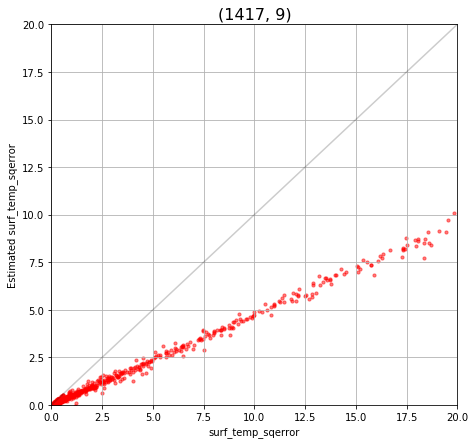

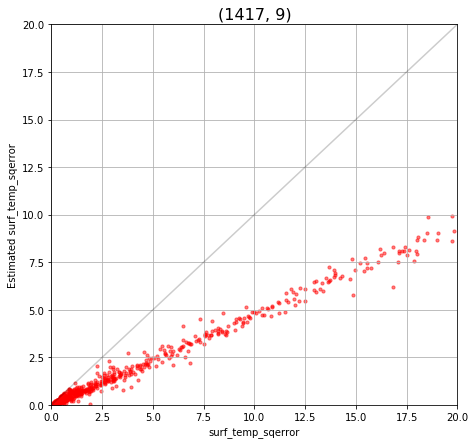

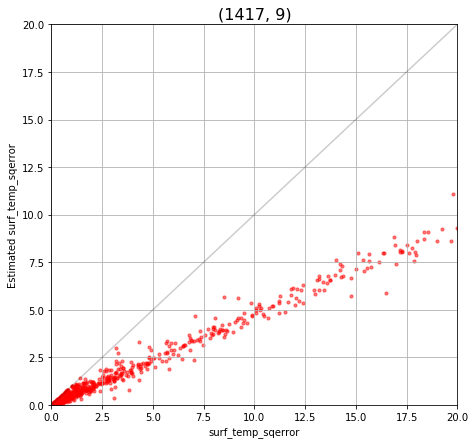

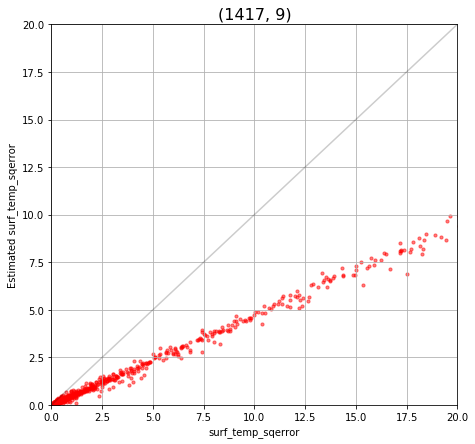

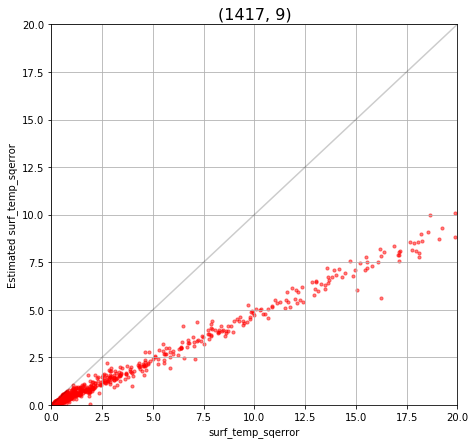

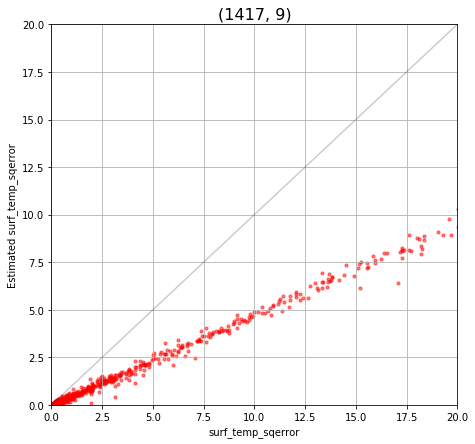

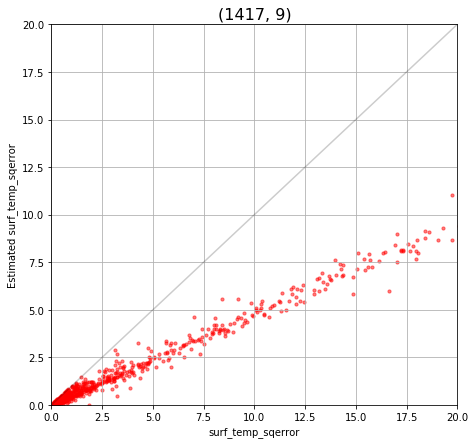

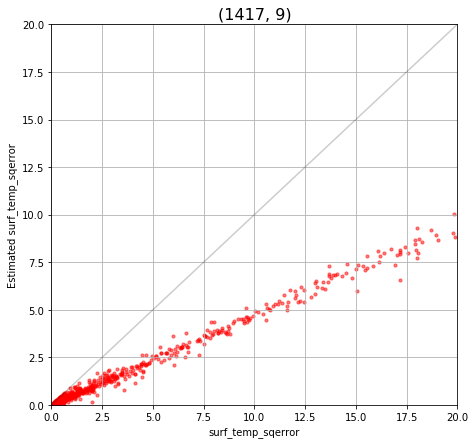

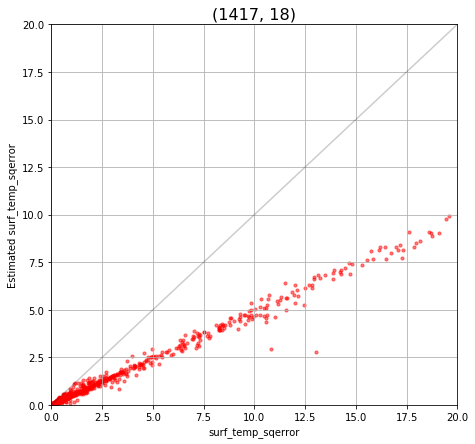

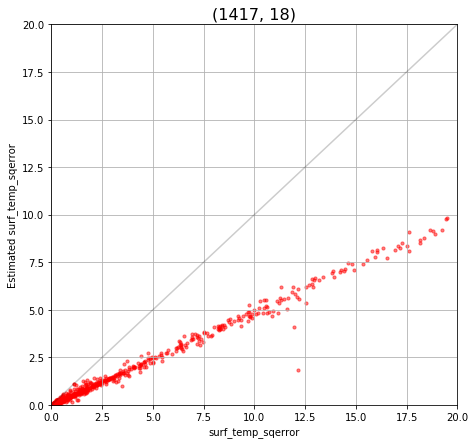

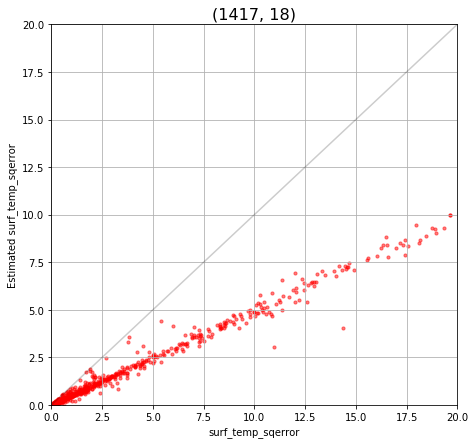

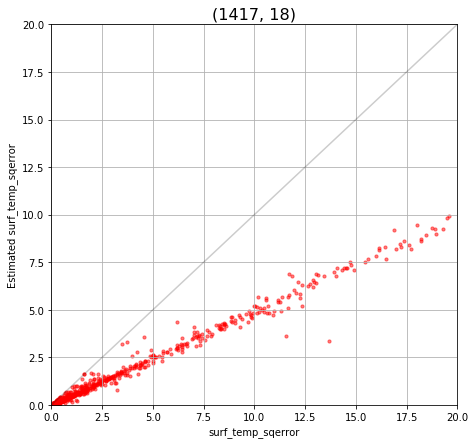

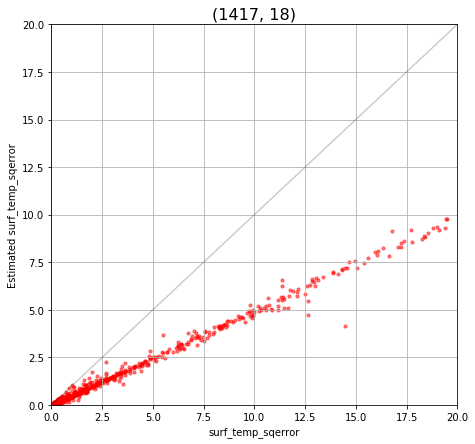

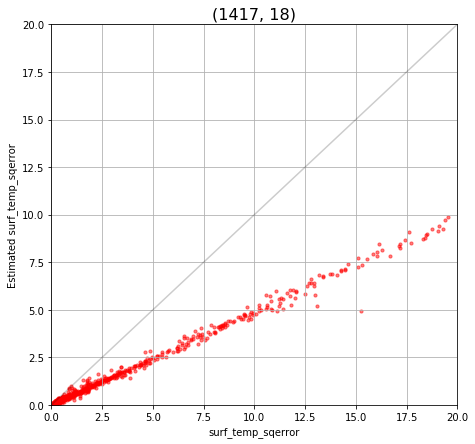

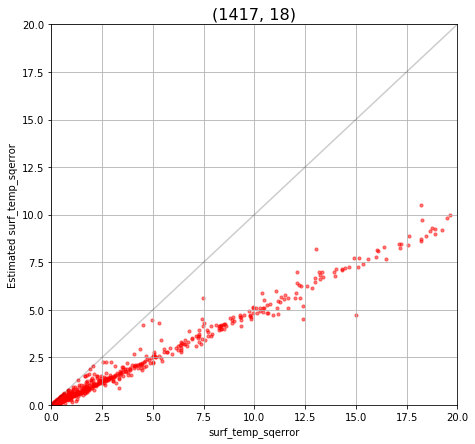

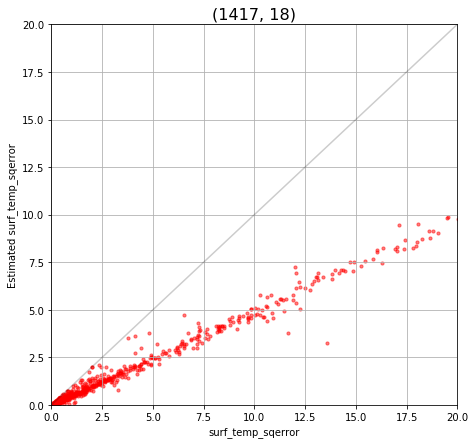

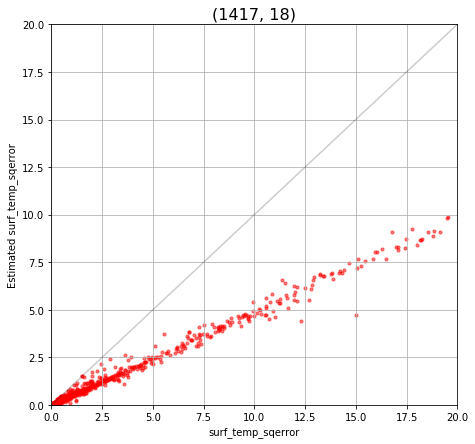

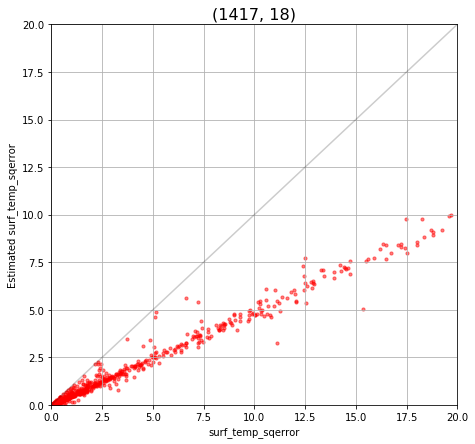

In [16]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

repeats = 10
features = 1
results = dict()
timesteps = 1

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        results[key] = experiment(repeats, df[key], features, timesteps, key)
    

In [163]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/rnn/data_{}.csv".format(str(key)))

    with open("results/rnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)